<html lang="en" class="h-100">
  <body>
    <div style='text-align:center'>Big Data Computing Project 2020/21</div>
    <h2 style='text-align:center'>Income Classification</h2>
    <h3 style='text-align:center'>Determine whether a person makes over 50K a year</h3>
    <hr>
    
    <p style='text-align:center'>Hassan Teymoori</p>
    <p style='text-align:center'>teymoori.1947458@studenti.uniroma1.it</p>
    <hr />
     <p style='text-align:center'>__Note__: The general structure of the notebook is inspired from the professor materials on the github</p>
  </body>
</html>

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
spark

Out[2]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## The Classification Task

In this Project, I will be using a dataset from [Kaggle](https://www.kaggle.com/lodetomasi1995/income-classification) containing many datapoints of the people. The version on the kaggle contains only 32K. I found the full version which contains almost 50K in the [UCI](https://archive.ics.uci.edu/ml/datasets/census+income) machine learning repository website.

The dataset is related to income evaluation of people. Each record (x, y) contains person information represented by means of 14 features (x1 = age, ...), along with a binary response (y: <=50K, >50K), which indicates whether the given person make income over than 50K (y = 1 or >50K) or not (y = 0 or <=50K).

The classification goal would be, given a new person information, to predict if she/he will make over 50K or less or equal than 50K.

# 1. Data Acquisition

This is the first step we need to accomplish before going any further. The dataset will be downloaded and loaded to DBFS, as usual.

### Download Dataset
Download the dataset to the local driver node's ```/tmp``` folder using ```wget```. Before start downloading the dataset , Let's create a directory for our dataset inside the dbfs. 
To start using the dataset I need to do the following:

<ol>
  <li>Create a directory in dbfs</li>
  <li>Download the dataset into the /tmp directory</li>
  <li>Move the file from local driver node's file system to DBFS</li>
</ol>

In [ ]:
%fs mkdirs bdc-project/dataset

res0: Boolean = true

In [ ]:
%sh wget -P /tmp https://github.com/hasanteymoori/bdc-project/raw/master/income_evaluation.csv.bz2

--2021-07-05 08:00:25-- https://github.com/hasanteymoori/bdc-project/raw/master/income_evaluation.csv.bz2
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hasanteymoori/bdc-project/master/income_evaluation.csv.bz2 [following]
--2021-07-05 08:00:25-- https://raw.githubusercontent.com/hasanteymoori/bdc-project/master/income_evaluation.csv.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348008 (340K) [application/octet-stream]
Saving to: ‘/tmp/income_evaluation.csv.bz2’

 0K .......... .......... .......... .......... .......... 14% 5.71M 0s
 50K .......... .......... .......... .......... .......... 29% 4.63M 0s
 100K .......... .......... .......... .......... .......... 44% 5.03M 0s
 150K .......... .......... .......... .......... .......... 58% 2.73M 0s
 200K .......... .......... .......... .......... .......... 73% 5.33M 0s
 250K .......... .......... .......... .......... .......... 88% 5.14M 0s
 300K .......... .......... .......... ......... 100% 4.14M=0.07s

2021-07-05 08:00:25 (4.44 MB/s) - ‘/tmp/income_evaluation.csv.bz2’ saved [348008/348008]

In [ ]:
%fs ls file:/tmp/

path,name,size
file:/tmp/rstudio-rsession/,rstudio-rsession/,4096
file:/tmp/tmp.m8MJCQT4fD,tmp.m8MJCQT4fD,0
file:/tmp/systemd-private-cfe12e3e8b0f4e36883f278e29fae94e-ntp.service-fNuViw/,systemd-private-cfe12e3e8b0f4e36883f278e29fae94e-ntp.service-fNuViw/,4096
file:/tmp/chauffeur-daemon-params,chauffeur-daemon-params,22
file:/tmp/chauffeur-env.sh,chauffeur-env.sh,156
file:/tmp/.X11-unix/,.X11-unix/,4096
file:/tmp/.XIM-unix/,.XIM-unix/,4096
file:/tmp/Rtmp8YcWZH/,Rtmp8YcWZH/,4096
file:/tmp/.font-unix/,.font-unix/,4096
file:/tmp/custom-spark.conf,custom-spark.conf,265


In [ ]:
# Move the downloaded file from local driver to DBFS
dbutils.fs.mv("file:/tmp/income_evaluation.csv.bz2", "dbfs:/bdc-project/dataset/income_evaluation.csv.bz2")
# %fs mv 'file:/tmp/income_evaluation.csv.bz2' 'dbfs:/bdc-project/dataset/income_evaluation.csv.bz2'

Out[428]: True

In [ ]:
%fs ls /bdc-project/dataset/

path,name,size
dbfs:/bdc-project/dataset/income_evaluation.csv.bz2,income_evaluation.csv.bz2,348008


### Load dataset
To read/load the dataset into a pyspark dataframe, I do the following

In [ ]:
income_dataframe = spark.read.load("dbfs:/bdc-project/dataset/income_evaluation.csv.bz2", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")
                          

### Dataset Structure 
I am going to see some usefull information about the my dataset like : 
**Number of rows and columns** (so-called dataset shape) and **dataset Schema**

In [ ]:
print(f'The dataset contains {income_dataframe.count()} rows.')
print(f'The dataset also has {len(income_dataframe.columns)} columns')

The dataset contains 48842 rows.
The dataset also has 15 columns


In [ ]:
income_dataframe.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



### Dataset Description

The dataset contains **48,842** historical records of people's yearly income; each record, contains the following set of **15** columns:

- `age`: the age of an individual Integer greater than 0 (_numerical_, _continuous_);

- `workclass`: a general term to represent the employment status of an individual: 
  - _[Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked]_ (_categorical_);

- `fnlwgt`: this is the number of people the census believes the entry represents.(_numerical_);

- `education`: the highest level of education achieved by an individual (_categorical_)
  - _[Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool]_

- `education-num`: the highest level of education achieved in numerical form (_numerical_);

- `marital-status`: marital status of an individual. Married-civ-spouse corresponds to a civilian spouse while Married-AF-spouse is a spouse in the Armed Forces. 
  - _[Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse]_ (_categorical_);

- `occupation`: the general type of occupation of an individual 
  - _[Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces]_(_categorical_);
  
- `relationship`:  represents what this individual is relative to others. For example an individual could be a Husband. Each entry only has one relationship attribute and is somewhat redundant with marital status. We might not make use of this attribute at all Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.(_categorical_);

- `race`: Descriptions of an individual’s race _[White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black]_(_categorical_);

- `sex`: the biological sex of the individual (_binary categorical_);
- `capital-gain`:  capital gains for an individual;
- `capital-loss`:  capital losses for an individual;
- `hours-per-week`:  the hours an individual has reported to work per week continuous;
- `native-country`:  country of origin for an individual _[United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands]_;

- **`income`**: whether or not an individual makes more than $50,000 annually. <= 50K, >50K (_categorical: binary_); **[This is the _target_ variable we want to classify or predict]**

### Dataset Observation
<ul>
  <li>The dataset contains <b>9</b> categorical variables (contains also target variable) and <b>6</b> numerical variables</li>
  <li>The dataset has many categorical variable that are needed to be encoded</li>
  <li><b>income</b> is the target variable</li>
  <li><b>Numerical variables</b> have type <i>integer</i></li>
  <li>The native_country has too many distinct values known as cardinality in ML</li>
</ul>

In [ ]:
# Display first 5 rows
display(income_dataframe.take(5))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Check missing values

In [ ]:
# This functions are responsible for checking the missing values in dataframe either spark or pandas df
def missing_values(columns):
  for column in columns:
    count = income_dataframe.where(col(column).isNull()).count()
    print(f"Number of missing values in column `{column}` = {count}")
    
    
def missing_values_pandas(df):
  # Total missing values
  mising_values = df.isnull().sum()
        
  # Percentage of missing values
  mising_values_percent = (100 * df.isnull().sum() / len(df))
        
  # Make a table with the results
  mising_values_pdf= pd.concat([
    mising_values, mising_values_percent
  ], axis=1).rename(
    columns = {0 : 'Missing Values', 1 : 'Ratio %'}
  )
      
  # Sort the table by percentage of missing descending
  mising_values_pdf = mising_values_pdf[
    mising_values_pdf.iloc[:,1] != 0].sort_values(
    'Ratio %', ascending=False).round(1)
    
  # Return the dataframe with missing information
  return mising_values_pdf

In [ ]:
missing_values(income_dataframe.columns)

Number of missing values in column `age` = 0
Number of missing values in column `workclass` = 0
Number of missing values in column `fnlwgt` = 0
Number of missing values in column `education` = 0
Number of missing values in column `education_num` = 0
Number of missing values in column `marital_status` = 0
Number of missing values in column `occupation` = 0
Number of missing values in column `relationship` = 0
Number of missing values in column `race` = 0
Number of missing values in column `sex` = 0
Number of missing values in column `capital_gain` = 0
Number of missing values in column `capital_loss` = 0
Number of missing values in column `hours_per_week` = 0
Number of missing values in column `native_country` = 0
Number of missing values in column `income` = 0

**<h3><font style='color:#d26523'>Observations<font></h1>**<br>
In the first glance it seems there is no missing values in the dataset. but to ensure I will apply some other approches.

### Dataset Categorization
I am going to create a constant for each type of the data into the dataset. As I saw in the previous cells my dataset contains **categorical variables** and **numerical variables**. I will create two different constants for each of them.
Also I create another constants for target variable only.

In [ ]:
categorical_features  = [
  column[0] for column in income_dataframe.dtypes if column[1].startswith('string')
]
numerical_features  = [
  column[0] for column in income_dataframe.dtypes if column[1].startswith('int')
]

if 'income' in categorical_features:
  categorical_features.remove('income')

print(f'There are {len(numerical_features)} numerical variables as following: \n', numerical_features, '\n')
print(f'There are {len(categorical_features)} categorical variables\n', categorical_features)

There are 6 numerical variables as following: 
 ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'] 

There are 8 categorical variables
 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

In [ ]:
TARGET_VARIABLE = "income"

CATEGORICAL_FEATURES = categorical_features
NUMERICAL_FEATURES = numerical_features

LENGTH_DF= income_dataframe.count()

COLOR_PRIMARY = '#007bff'
COLOR_SECONDARY = '#6c757d'
COLOR_SUCCESS = '#28a745'
COLOR_DANGER = '#dc3545'
COLOR_WARNING = '#ffc107'
COLOR_INFO = '#17a2b8'
COLOR_DARK = '#343a40'

In [ ]:
income_dataframe.select(CATEGORICAL_FEATURES).show(n=5)
income_dataframe.select(NUMERICAL_FEATURES).show(n=5)

+----------------+---------+------------------+-----------------+-------------+-----+------+--------------+
|       workclass|education|    marital_status|       occupation| relationship| race|   sex|native_country|
+----------------+---------+------------------+-----------------+-------------+-----+------+--------------+
|       State-gov|Bachelors|     Never-married|     Adm-clerical|Not-in-family|White|  Male| United-States|
|Self-emp-not-inc|Bachelors|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male| United-States|
|         Private|  HS-grad|          Divorced|Handlers-cleaners|Not-in-family|White|  Male| United-States|
|         Private|     11th|Married-civ-spouse|Handlers-cleaners|      Husband|Black|  Male| United-States|
|         Private|Bachelors|Married-civ-spouse|   Prof-specialty|         Wife|Black|Female|          Cuba|
+----------------+---------+------------------+-----------------+-------------+-----+------+--------------+
only showing top 5 rows

+--

# 2. Data Exploration

Before starting with learning pipline of any  modeling technique, line any Machine Learning task, a best practice is  to explore your dataset and calculate a few statistics from your data. In addition, drawing specific plots may help us spot interesting facts like correlations, outliers and etc.

### Summary Statistics
As a first exploration let's see descriptive statistics of the dataset

In [ ]:
income_dataframe.describe().toPandas()

Out[444]:

,summary,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
1,mean,38.64358543876172,None,189664.13459727284,None,10.078088530363212,None,None,None,None,None,1079.0676262233324,87.50231358257237,40.422382375824085,None,None
2,stddev,13.710509934443623,None,105604.02542315776,None,2.5709727555922672,None,None,None,None,None,7452.01905765544,403.0045521243612,12.391444024252277,None,None
3,min,17,?,12285,10th,1,Divorced,?,Husband,Amer-Indian-Eskimo,Female,0,0,1,?,<=50K
4,max,90,Without-pay,1490400,Some-college,16,Widowed,Transport-moving,Wife,White,Male,99999,4356,99,Yugoslavia,>50K


### To Pandas
In order for me to be able to access plotting libraries ( like matplotlib and seaborn ), I need to  transform the PySpark DataFrame into a __Pandas DataFrame__ as we have seen it in the class

In [ ]:
# transform our PySpark DataFrame into a Pandas DataFrame
income_pd = income_dataframe.toPandas() 

## Data Distributions: Numerical
In this section we will see some distribution of the columns with respect to each other or target variable

### 1. Distribution Plot of Numerical features

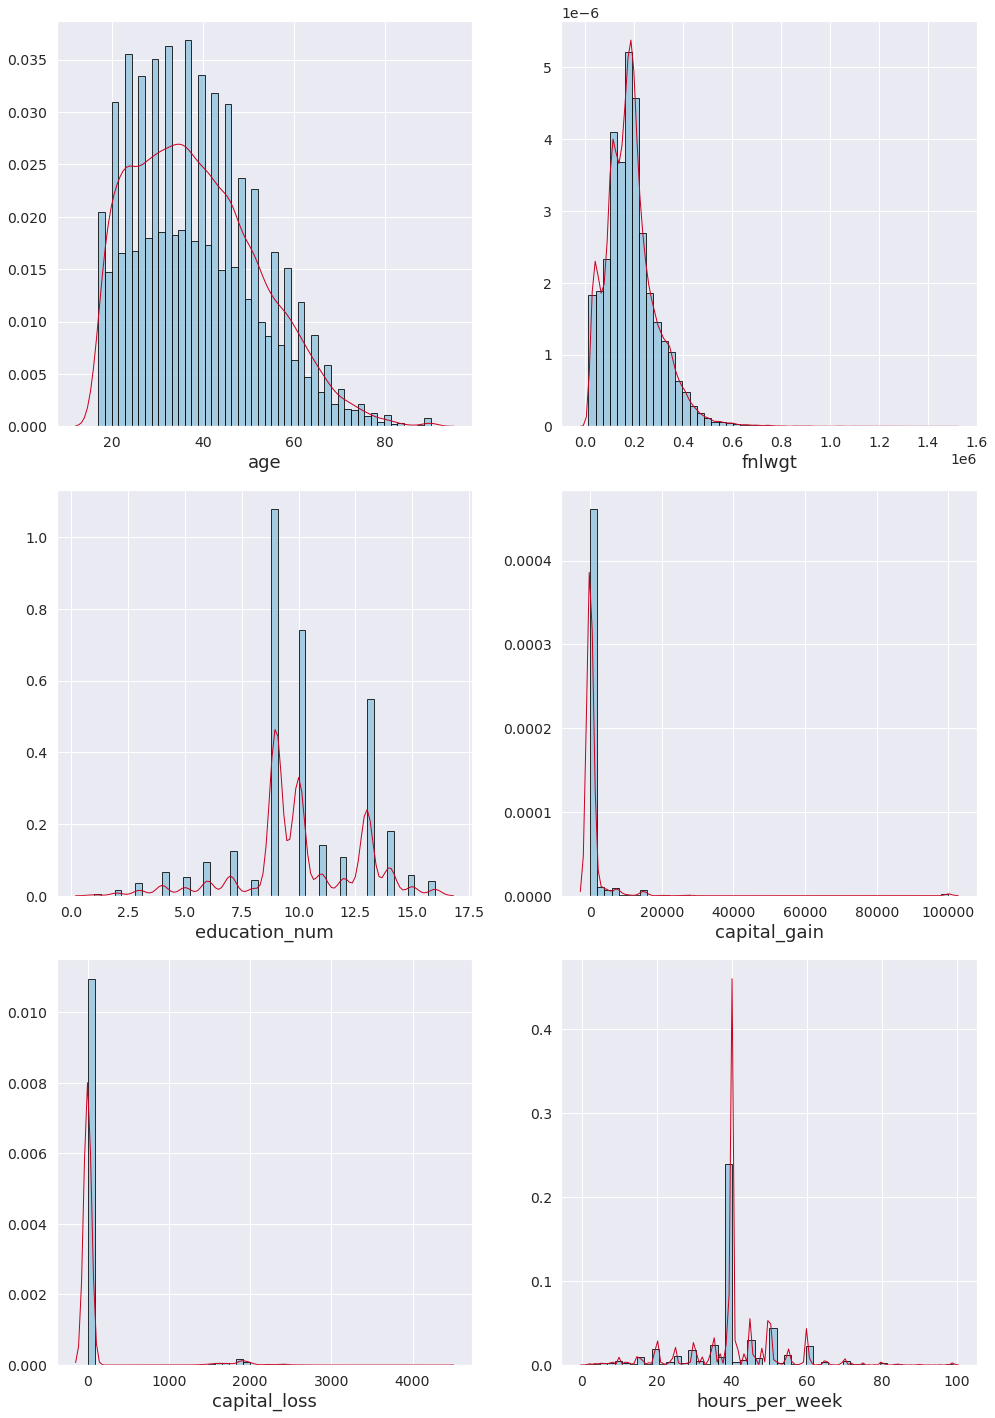

In [ ]:
# Plot the distribution of values of each column of interest
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,20))

for i,f in enumerate(NUMERICAL_FEATURES):
    _ = sns.distplot(income_pd[f],
                    kde_kws={"color": "#ca0020", "lw": 1}, 
                    hist_kws={"histtype": "bar", "edgecolor": "k", "linewidth": 1,"alpha": 0.8, "color": "#92c5de"},
                    ax=axes[i//n_cols, i%n_cols]
                    )

# fig.delaxes(axes[3][1]) # Remove the last cell of the plot

fig.tight_layout(pad=1.5)

### 2. Pairwise regression plots

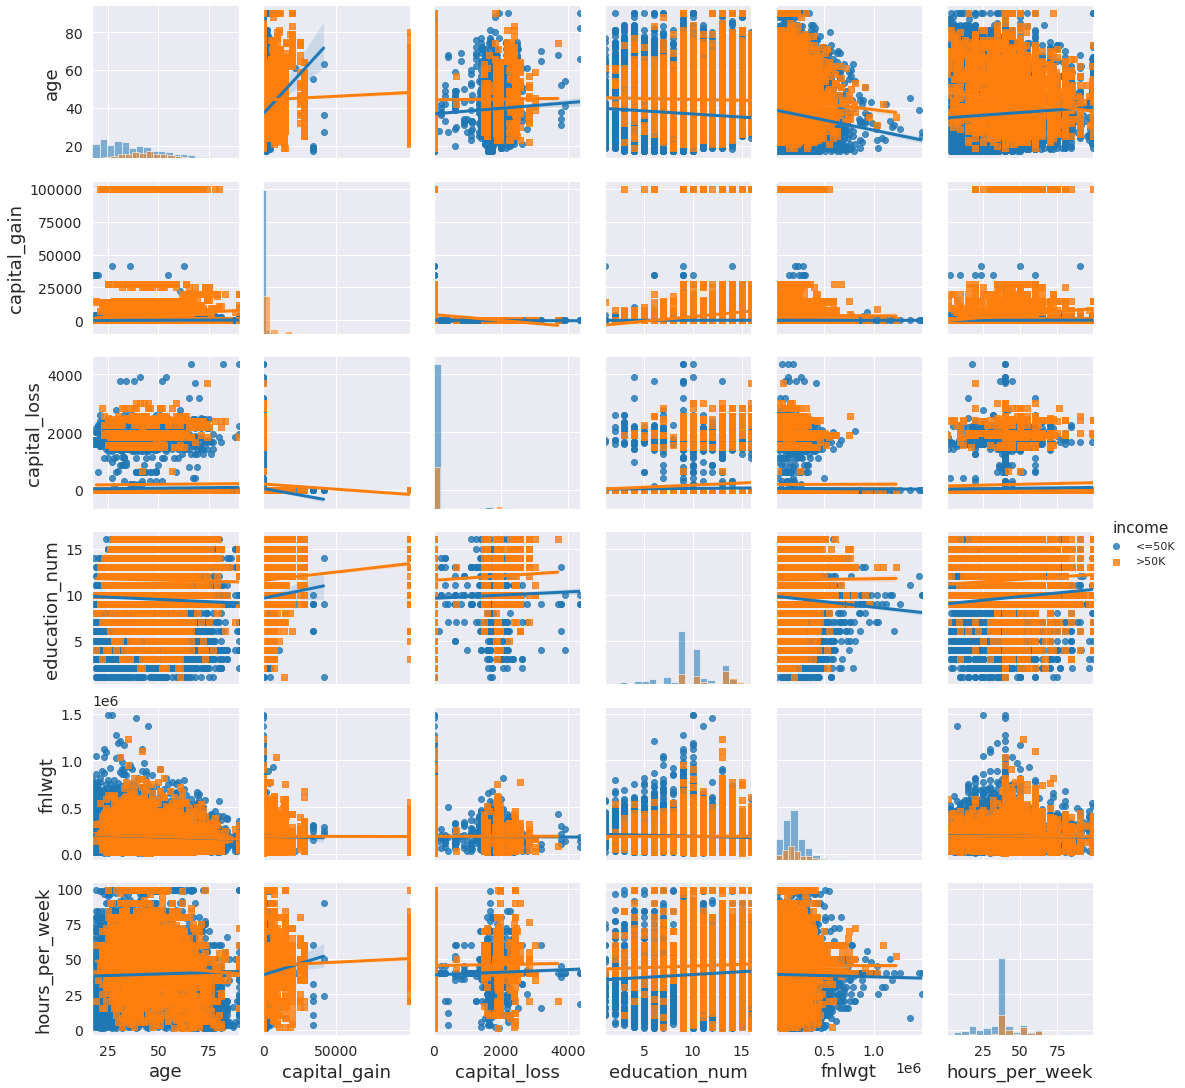

In [ ]:
# Let's now plot the pairwise relationship between our numerical features
_ = sns.pairplot(data=income_pd, 
                 vars=sorted(NUMERICAL_FEATURES), 
                 hue=TARGET_VARIABLE, 
                 kind="reg",
                 diag_kind='hist',
                 diag_kws = {'alpha':0.55, 'bins':20},
                 markers=["o", "s"]
                )

**<h3><font style='color:#d26523'>Observations<font></h1>**<br>
from figures above: both __distribution__ and __regression__ <hr />
  
  - `Age`, `fnlwgt`, `capital_gain` certainly don’t follow a normal distribution. => __Possitively Skewed__
  - There is no high correlation between numeric features.
  - I can also see that the columns all appear to have a __different scale__.
    - Depending on the choice of modeling algorithms, I would expect scaling the distributions to the equal range is useful
  <hr/>
Let's see the correlation matrix to verify this.

### 3. Correlation heatmap

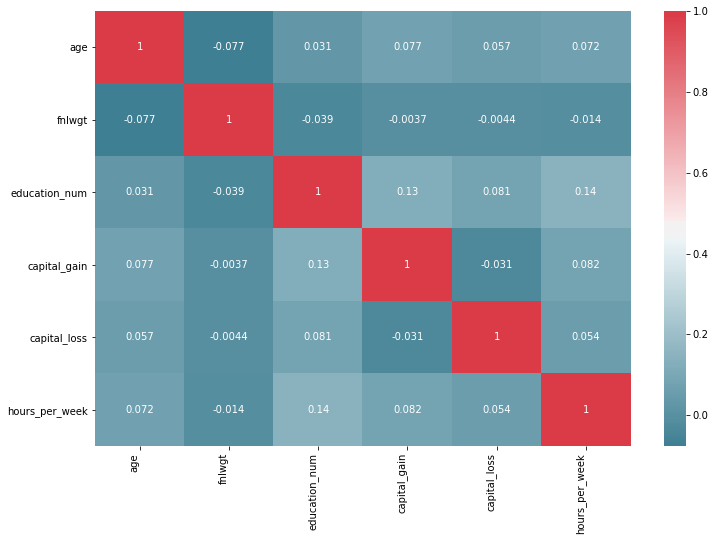

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

sns.heatmap(
  income_pd.corr(), 
  annot=True, 
  cmap=sns.diverging_palette(220, 10, as_cmap=True)
)

plt.show()
  

### 4. CountPlot of Categorical features

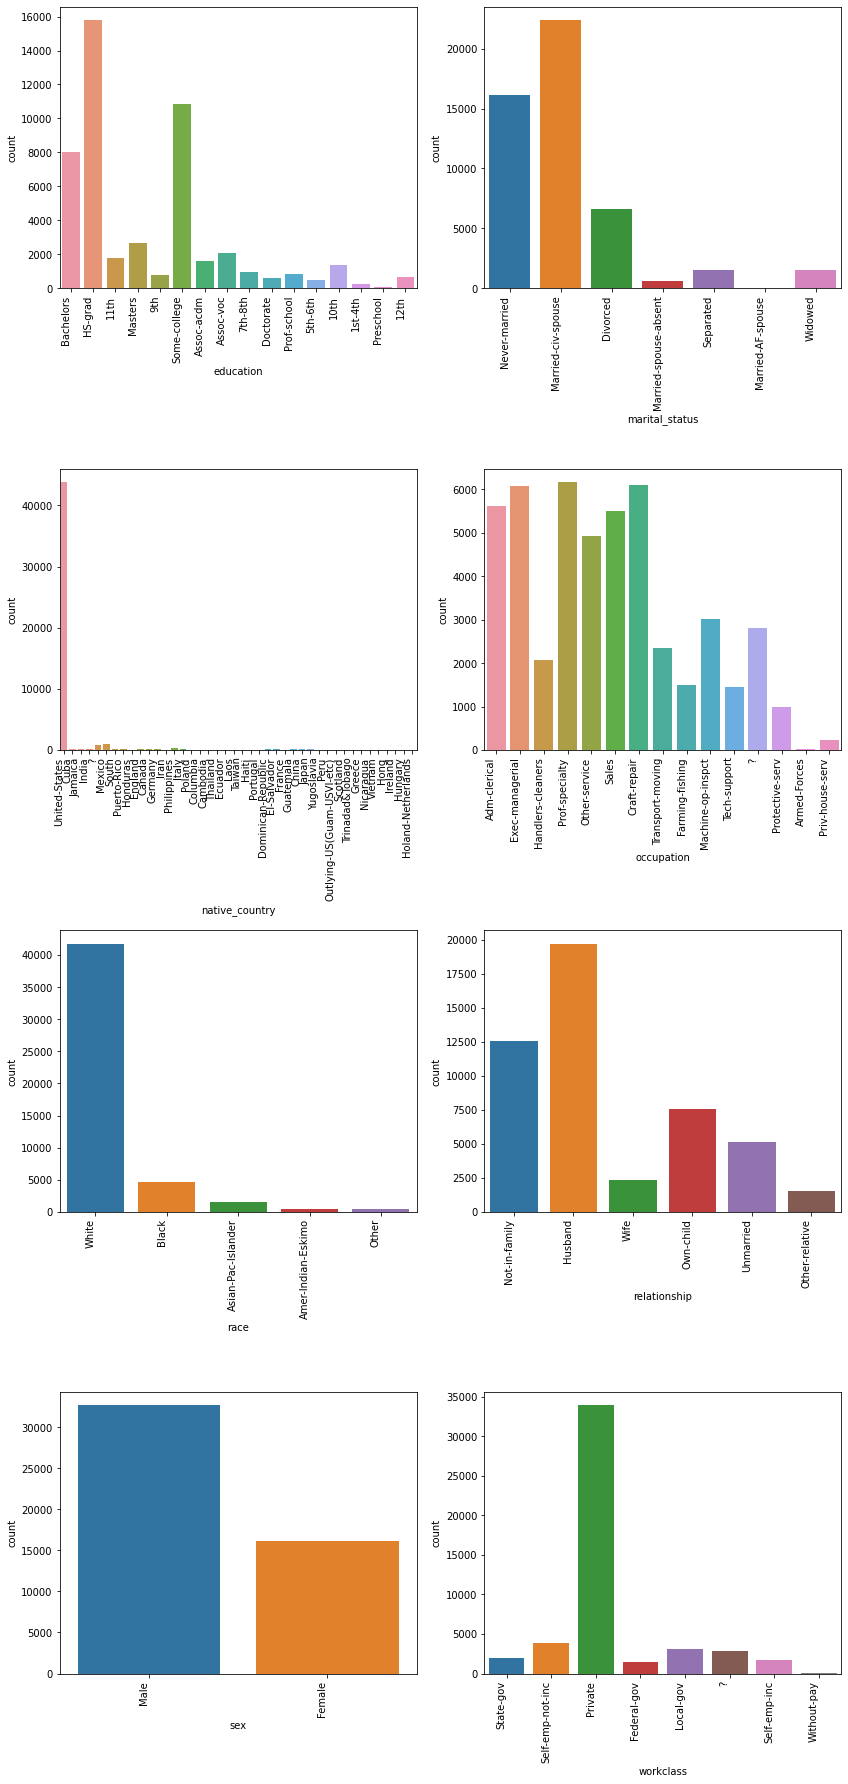

In [ ]:
# For categorical variables, 'countplot' is the way to go
# Create a Figure containing 3x3 subplots
n_rows = 4
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 25))

for i,f in enumerate(sorted(CATEGORICAL_FEATURES)): 
    ax = sns.countplot(income_pd[f], ax=axes[i//n_cols, i%n_cols])
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
    
fig.tight_layout(pad=1.5)

## Explore Variables
Many things can be seen in the above plots. Let's bring some of them up.
I am going to plot some of the varibles w.r.t target or other variables in order to find useful patterns. In the following there is a custom function which gives me the summary of single variable regarding value's count

In [ ]:
def countview(df, column, toPandas=True, with_percentage = True):
  """
    Args:
        - df: the input dataframe
        - column: the column name in `df` to be counted 
        - toPandas:(optional) the flag for dataframe in order to return the pandas dataframe or return the pyspark dataframe
        - with_percentage:(optional) the propotion of the column values with respect to the dataset length

    Return:
        - count_df: the new dataframe which contains column itself, count w.t.r groupBy and the percentage of each value
    """
  countview = df.groupBy(column).count().orderBy('count', ascending=False)
  
  countview = countview if with_percentage==False else countview.withColumn('percentage_of_each_value', round((col('count')/LENGTH_DF)*100 , 2))
  
  count_df = countview.toPandas() if toPandas else countview
  
  
  return count_df

### Target variable

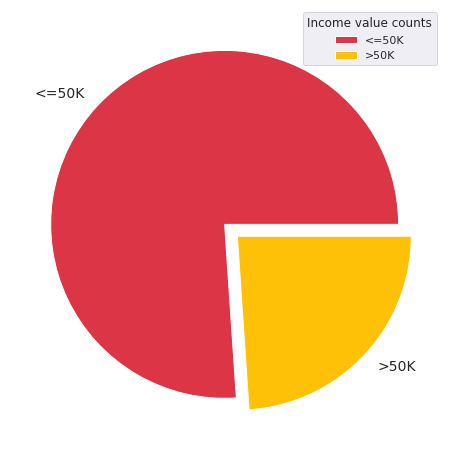

In [ ]:
target_pdf = countview(income_dataframe, TARGET_VARIABLE)

# Plot the distribution of values of each column of interest
fig, axes = plt.subplots(figsize=(16,8))

axes.pie(
  target_pdf['count'],
  colors = [COLOR_DANGER, COLOR_WARNING] ,
  labels = target_pdf[TARGET_VARIABLE], 
  explode=(0, 0.1)
)

axes.legend(title = "Income value counts")
fig.show() 

**<h3><font style='color:#d26523'>Observations<font></h1>**<br>
- As you can see in the above figure our dataset is not well-balanced! ( it is not very unbalanced but of course it need to be taken into consideration) The classes are imbalanced, with a skew toward the ‘<=50K‘ class label.
  <ul>
    <li>The majority is related to entries with income = '<=50K'</li>
    <li>The minority is related to entries with income = '>50K'</li>
  </ul>
  
- I can also see that the target variable is represented as strings. This column will need to be  encoded.

### Target variable & Sex
Visualization of the target variable with respect to the sex variable

Out[30]:

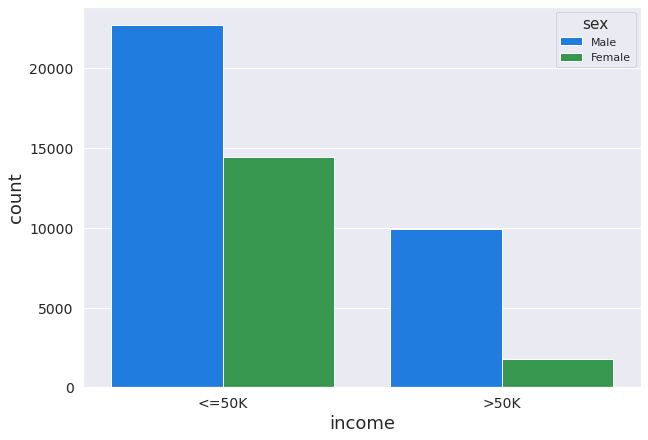

<matplotlib.axes._subplots.AxesSubplot at 0x7fa80a427760>

In [ ]:
figure, axes = plt.subplots(figsize=(10, 7))

sns.countplot(
  x=TARGET_VARIABLE, # y='income' # showing in y axes
  hue="sex",
  data=income_pd,
  palette = [COLOR_PRIMARY, COLOR_SUCCESS] 
)


**<h3><font style='color:#d26523'>Interpretation<font></h1>**<br>
At first glance it seems that males make more money than females in both the income categories. but in order to verify this interpretation we need to check the distribution of the males and females. In another word, in case the number of the males versus female is equal, then such interpretation would be correct.

### Sex variable
I am going to visualize the sex distribution in order to spot the previous interpretation

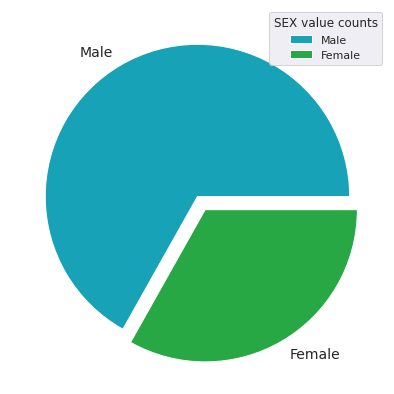

In [ ]:
sex_pdf = countview(income_dataframe, 'sex')
# Plot the distribution of values of each column of interest
figure, axes = plt.subplots(figsize=(10, 7))

axes.pie(
  sex_pdf['count'],
  colors = [COLOR_INFO, COLOR_SUCCESS] ,
  labels = sex_pdf['sex'], 
  explode=(0, 0.1)
)

axes.legend(title = "SEX value counts")
figure.show()

**<h3><font style='color:#d26523'>Outcome of the plot<font></h1>**<br>
At you can see,  number of the males in the dataset is larger than number of Females. therfore base on this result we can say **our previous interpretation is not correct**. => we can not surly say males makes more money than females!

### Target variable & Race
Visualization of the target variable with respect to the race variable

Out[479]:

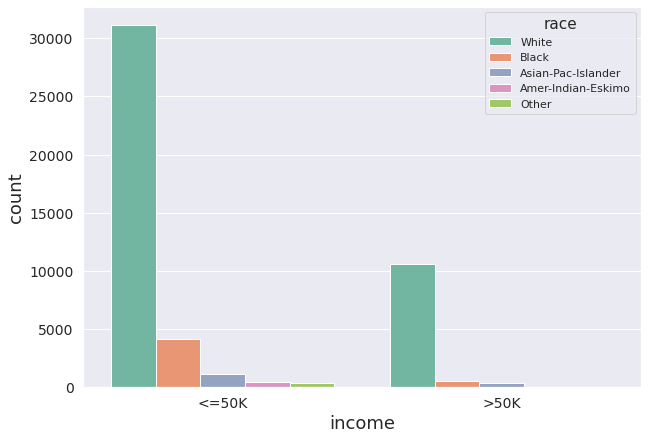

<matplotlib.axes._subplots.AxesSubplot at 0x7fa80246f2e0>

In [ ]:
figure, axes = plt.subplots(figsize=(10, 7))

sns.countplot(
  x=TARGET_VARIABLE, # y='income' # showing in y axes
  hue="race",
  data=income_pd,
  palette = 'Set2'
)

**<h3><font style='color:#d26523'>Interpretation<font></h1>**<br>
We can see that whites make more money than non-whites in both the income categories. but again we need to check the distribution of the race variable in the dataset

### Race variable
I am going to visualize the race distribution in order to spot the previous interpretation

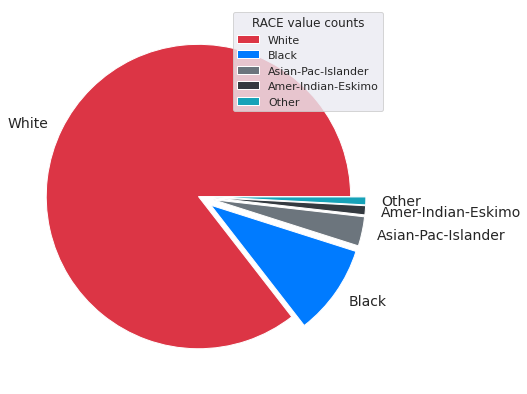

In [ ]:
race_pdf = countview(income_dataframe, 'race')


# Plot the distribution of values of each column of interest
figure, axes = plt.subplots(figsize=(10, 7))

axes.pie(
  race_pdf['count'],
  colors = [COLOR_DANGER, COLOR_PRIMARY, COLOR_SECONDARY, COLOR_DARK, COLOR_INFO] ,
  labels = race_pdf['race'], 
  explode=(0, 0.1, 0.1, 0.1, 0.1)
)

axes.legend(title = "RACE value counts")
figure.show()

**<h3><font style='color:#d26523'>Outcome of the plot<font></h1>**<br>
Again our interpretation is not correct since the number of the different race categories is not equal with respect to each other.

### Workclass Variable
Let's check the countview of the workclass values. countview has been defined in the above sections.

In [ ]:
workclass = countview(income_dataframe, 'workclass', toPandas=False)
workclass.show()

+----------------+-----+------------------------+
|       workclass|count|percentage_of_each_value|
+----------------+-----+------------------------+
|         Private|33906|                   69.42|
|Self-emp-not-inc| 3862|                    7.91|
|       Local-gov| 3136|                    6.42|
|               ?| 2809|                    5.75|
|       State-gov| 1981|                    4.06|
|    Self-emp-inc| 1695|                    3.47|
|     Federal-gov| 1432|                    2.93|
|     Without-pay|   21|                    0.04|
+----------------+-----+------------------------+



Out[19]: <matplotlib.axes._subplots.AxesSubplot at 0x7fec72e15c10>

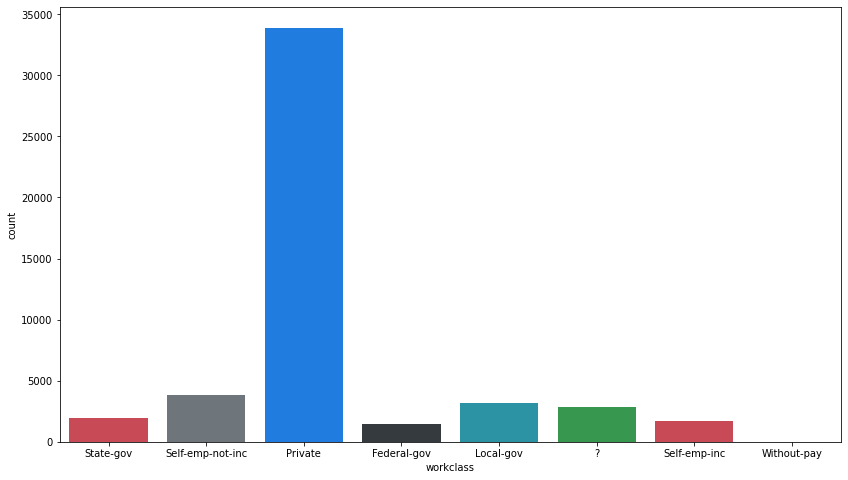

In [ ]:

figure, axes = plt.subplots(figsize=(14, 8))

sns.countplot(
  x='workclass', # y='income' # showing in y axes
  data=income_pd,
  palette = [COLOR_DANGER, COLOR_SECONDARY, COLOR_PRIMARY,COLOR_DARK, COLOR_INFO, COLOR_SUCCESS] 
)

**<h3>👀 <font style='color:#d26523'>Observations<font></h1>**<br>
There are a couple of things need to be considered in the above diagram:
  <ul>
    <li>There are more __private__ workers than other group of workers.</li>
    <li>There are __2809__ values encoded as ? in workclass variable which was unknown for me before.</li>
  </ul>
  
  
**<h3>✅ <font style='color:#2ca217'>Outcome<font></h1>**
  
While at the first exploration I realized that there is __<font style='red'>no missing value</font>__, Here I can see that there are __2809__ values encoded as __<font>?</font>__ in workclass variable. which is kinda considered as __*missing value*__. In the feature engineering section I will replace them with most frequent value.
For now let me just replace it with __<font>None</font>__ in order to introduce it to the python interpreter as a missing value.
<hr>

**<h4>📚 <font style='color:#1781a2'>Important Notes<font></h1>**
  <ul>
    <li>The missing values are coded as __NaN, None, null, nan__</li>
    <li>Sometimes The missing values are coded as special chars like __?__, which Python fail to detect these as missing values</li>
    <li>We need to be carful about them, replacing the ? with NaN so as to let python detect these missing values.</li>
  </ul>

In [ ]:
# replace '?' values in workclass variable with `NaN`
income_dataframe = income_dataframe.withColumn(
  "workclass", when(income_dataframe.workclass == "?" , None).otherwise(income_dataframe.workclass)
)
# update the new version of the pandas dataframe
income_pd = income_dataframe.toPandas()


In [ ]:
workclass = countview(income_dataframe, 'workclass', toPandas=False)
workclass.show()

+----------------+-----+------------------------+
|       workclass|count|percentage_of_each_value|
+----------------+-----+------------------------+
|         Private|33906|                   69.42|
|Self-emp-not-inc| 3862|                    7.91|
|       Local-gov| 3136|                    6.42|
|            null| 2809|                    5.75|
|       State-gov| 1981|                    4.06|
|    Self-emp-inc| 1695|                    3.47|
|     Federal-gov| 1432|                    2.93|
|     Without-pay|   21|                    0.04|
+----------------+-----+------------------------+



### Occupation Variable
Let's check the countview of the occupation values. countview has been defined in the above sections.

In [ ]:
countview(income_dataframe, 'occupation', toPandas=False).show()

+-----------------+-----+------------------------+
|       occupation|count|percentage_of_each_value|
+-----------------+-----+------------------------+
|   Prof-specialty| 6172|                   12.64|
|     Craft-repair| 6112|                   12.51|
|  Exec-managerial| 6086|                   12.46|
|     Adm-clerical| 5611|                   11.49|
|            Sales| 5504|                   11.27|
|    Other-service| 4923|                   10.08|
|Machine-op-inspct| 3022|                    6.19|
|                ?| 2809|                    5.75|
| Transport-moving| 2355|                    4.82|
|Handlers-cleaners| 2072|                    4.24|
|  Farming-fishing| 1490|                    3.05|
|     Tech-support| 1446|                    2.96|
|  Protective-serv|  983|                    2.01|
|  Priv-house-serv|  242|                     0.5|
|     Armed-Forces|   15|                    0.03|
+-----------------+-----+------------------------+



Out[24]: <matplotlib.axes._subplots.AxesSubplot at 0x7fec720a6610>

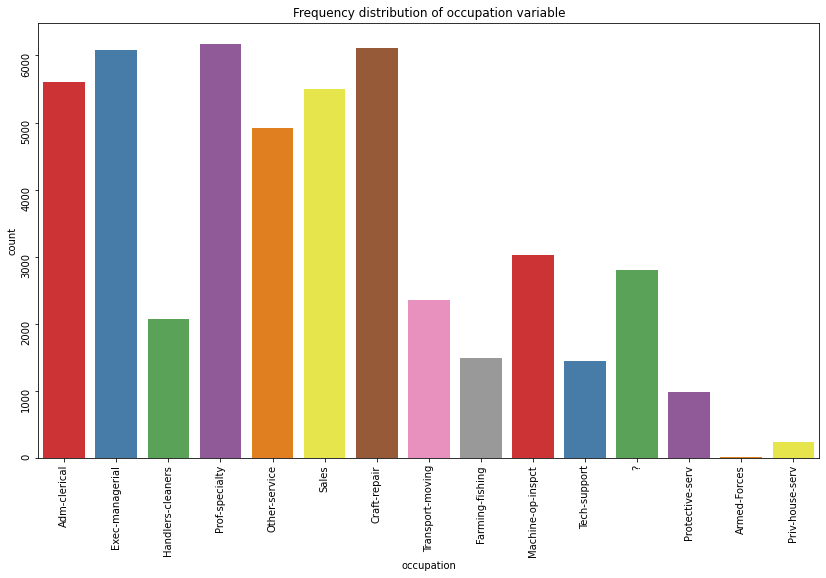

In [ ]:

figure, axes = plt.subplots(figsize=(14, 8))
axes.set_title("Frequency distribution of occupation variable")

axes.tick_params(labelrotation=90)

sns.countplot(
  x='occupation', # y='income' # showing in y axes
  data=income_pd,
  palette = "Set1"
)

**<h3><font style='color:#d26523'>Observations<font></h1>**
  
While at the first exploration I realized that there is __<font style='red'>no missing value</font>__ in this column, here I can perfectly see that there are __2809__ values encoded as __<font style='red'>?</font>__ in occupation variable just like workclass. which is kinda considered as __*missing value*__. In the feature engineering section I will replace them with most frequent value. 
  
<hr>
__For now let me just replace it with __<font style='red'>None</font>__ in order to introduce it to the python interpreter as a missing value__

In [ ]:
# replace '?' values in occupation variable with `NaN`
income_dataframe = income_dataframe.withColumn(
  "occupation", when(income_dataframe.occupation == "?" , None).otherwise(income_dataframe.occupation)
)
# update the new version of the pandas dataframe
income_pd = income_dataframe.toPandas()

In [ ]:
countview(income_dataframe, 'occupation', toPandas=False).show()

+-----------------+-----+------------------------+
 occupation|count|percentage_of_each_value|
+-----------------+-----+------------------------+
 Prof-specialty| 6172| 12.64|
 Craft-repair| 6112| 12.51|
 Exec-managerial| 6086| 12.46|
 Adm-clerical| 5611| 11.49|
 Sales| 5504| 11.27|
 Other-service| 4923| 10.08|
Machine-op-inspct| 3022| 6.19|
 null| 2809| 5.75|
 Transport-moving| 2355| 4.82|
Handlers-cleaners| 2072| 4.24|
 Farming-fishing| 1490| 3.05|
 Tech-support| 1446| 2.96|
 Protective-serv| 983| 2.01|
 Priv-house-serv| 242| 0.5|
 Armed-Forces| 15| 0.03|
+-----------------+-----+------------------------+

### Native_country Variable
Let's check the countview of the native_country values. countview has been defined in the above sections.

In [ ]:
countview(income_dataframe, 'native_country', toPandas=False).show(n=10)

+--------------+-----+------------------------+
|native_country|count|percentage_of_each_value|
+--------------+-----+------------------------+
| United-States|43832|                   89.74|
|        Mexico|  951|                    1.95|
|             ?|  857|                    1.75|
|   Philippines|  295|                     0.6|
|       Germany|  206|                    0.42|
|   Puerto-Rico|  184|                    0.38|
|        Canada|  182|                    0.37|
|   El-Salvador|  155|                    0.32|
|         India|  151|                    0.31|
|          Cuba|  138|                    0.28|
+--------------+-----+------------------------+
only showing top 10 rows



**<h3><font style='color:#d26523'>Observations<font></h1>**
  
Just like workclass and occupation variables there are __857__ missing values encoded as __?__ in this column. 
<hr>
__For now let me just replace it with __<font style='red'>None</font>__ in order to introduce it to the python interpreter as a missing value__

In [ ]:
# replace '?' values in native_country variable with `NaN`
income_dataframe = income_dataframe.withColumn(
  "native_country", when(income_dataframe.native_country == "?" , None).otherwise(income_dataframe.native_country)
)
# update the new version of the pandas dataframe
income_pd = income_dataframe.toPandas()

In [ ]:
countview(income_dataframe, 'native_country', toPandas=False).show(n= 10)

+--------------+-----+------------------------+
|native_country|count|percentage_of_each_value|
+--------------+-----+------------------------+
| United-States|43832|                   89.74|
|        Mexico|  951|                    1.95|
|          null|  857|                    1.75|
|   Philippines|  295|                     0.6|
|       Germany|  206|                    0.42|
|   Puerto-Rico|  184|                    0.38|
|        Canada|  182|                    0.37|
|   El-Salvador|  155|                    0.32|
|         India|  151|                    0.31|
|          Cuba|  138|                    0.28|
+--------------+-----+------------------------+
only showing top 10 rows



Out[28]: <matplotlib.axes._subplots.AxesSubplot at 0x7fec72031090>

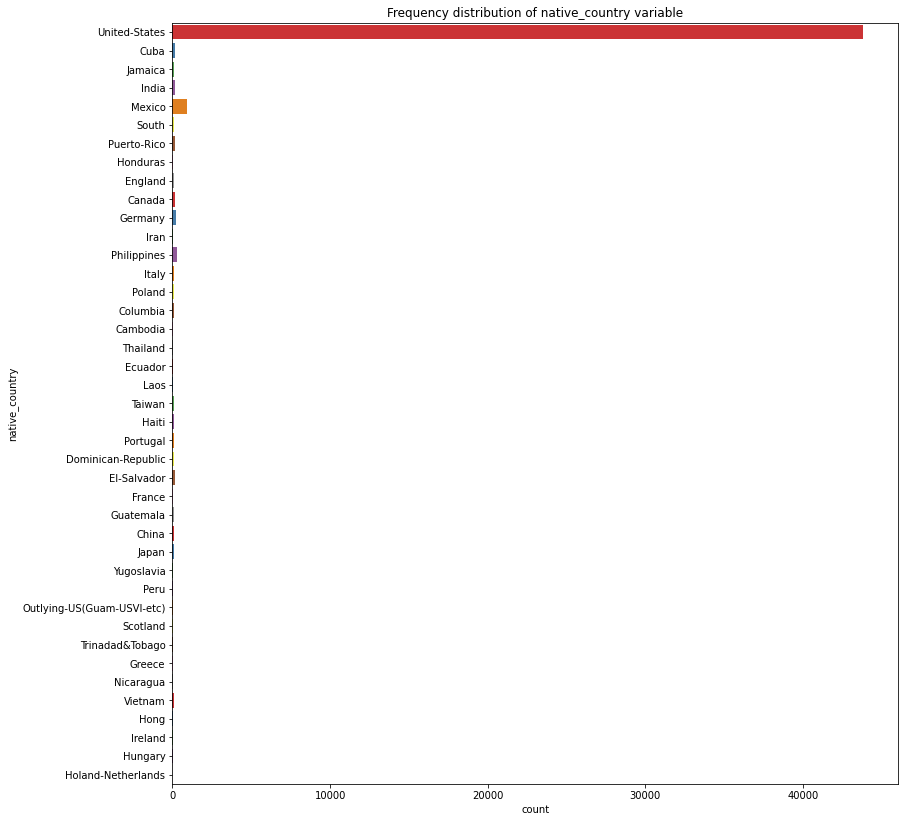

In [ ]:

figure, axes = plt.subplots(figsize=(13, 14))
axes.set_title("Frequency distribution of native_country variable")

sns.countplot(
  y='native_country', # y='income' # showing in y axes
  data=income_pd,
  palette="Set1"
)

**<h3><font style='color:#d26523'>Observations<font></h1>**

  - It is obvious that a lot of samples are taken from only the united states. 
  - This column contains many values which could be a problem for any machine learning application. This is problem known as `Cardinality` in ML.
  - Since it is a categorical feature, it should be encoded. But this can lead to sparsity. (many values, 42-dimensions)

### Missing Values
Now let's see by applying the changes on the dataset, is the python interpreter able to show the missing values or not. Also to visualise the missing value I use the missingno package.

In [ ]:
# print the number of the missing values per column
missing_values(income_dataframe.columns)
print('-------------------------------------------------------------')

# Show the pandas table of the columns which have missing values
missing_values_pandas(income_pd)

Number of missing values in column `age` = 0
Number of missing values in column `workclass` = 2809
Number of missing values in column `fnlwgt` = 0
Number of missing values in column `education` = 0
Number of missing values in column `education_num` = 0
Number of missing values in column `marital_status` = 0
Number of missing values in column `occupation` = 2809
Number of missing values in column `relationship` = 0
Number of missing values in column `race` = 0
Number of missing values in column `sex` = 0
Number of missing values in column `capital_gain` = 0
Number of missing values in column `capital_loss` = 0
Number of missing values in column `hours_per_week` = 0
Number of missing values in column `native_country` = 857
Number of missing values in column `income` = 0
-------------------------------------------------------------
Out[15]:

,Missing Values,Ratio %
workclass,2809,5.8
occupation,2809,5.8
native_country,857,1.8


**<h3><font style='color:#d26523'>Interpretation<font></h1>**

There is the exact number of missing values in workclass and occupation. I assume it could not be by chance, they can have missing value on the same instances. Let visualize it.

In [ ]:
!pip install missingno

Collecting missingno
 Downloading missingno-0.5.0-py3-none-any.whl (8.8 kB)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from missingno) (3.2.2)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from missingno) (1.19.2)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from missingno) (1.5.2)
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.8/site-packages (from missingno) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->missingno) (1.3.0)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->missingno) (2.8.1)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->missingno) (2.4.7)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->missingno) (0.10.0)
Requirement already satisfied: pandas>=0.22.0 in /databricks/python3/lib/python3.8/site-packages (from seaborn->missingno) (1.1.5)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.8/site-packages (from python-dateutil>=2.1->matplotlib->missingno) (1.15.0)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.22.0->seaborn->missingno) (2020.5)
Installing collected packages: missingno
Successfully installed missingno-0.5.0
 WARNING: You are using pip version 20.2.4; however, version 21.1.3 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

Out[17]:

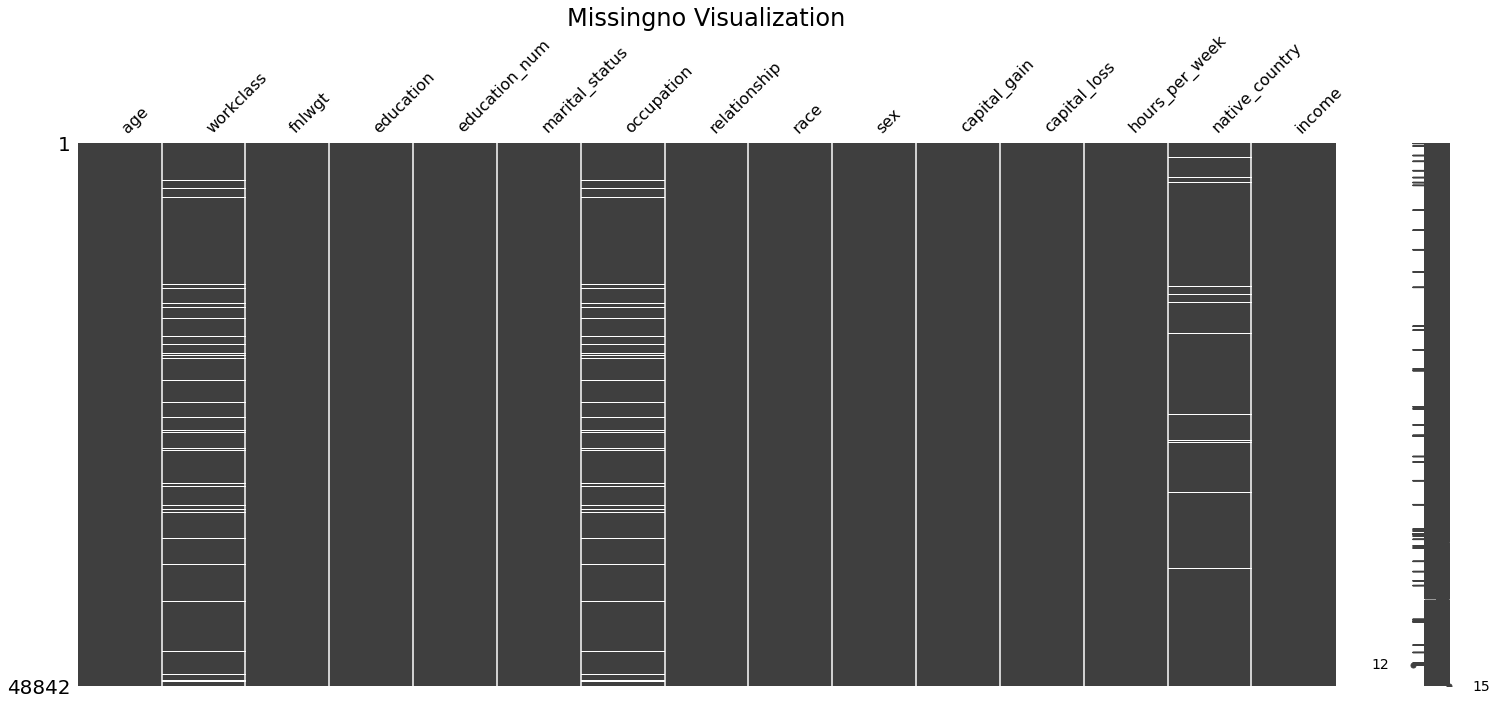

Text(0.5, 1.0, 'Missingno Visualization')

In [ ]:

import missingno as msno
msno.matrix(income_pd)
plt.title('Missingno Visualization', fontsize=24)


It seems that my interpretation is correct. to ensure I will zoom to the missing value columns.

Out[18]:

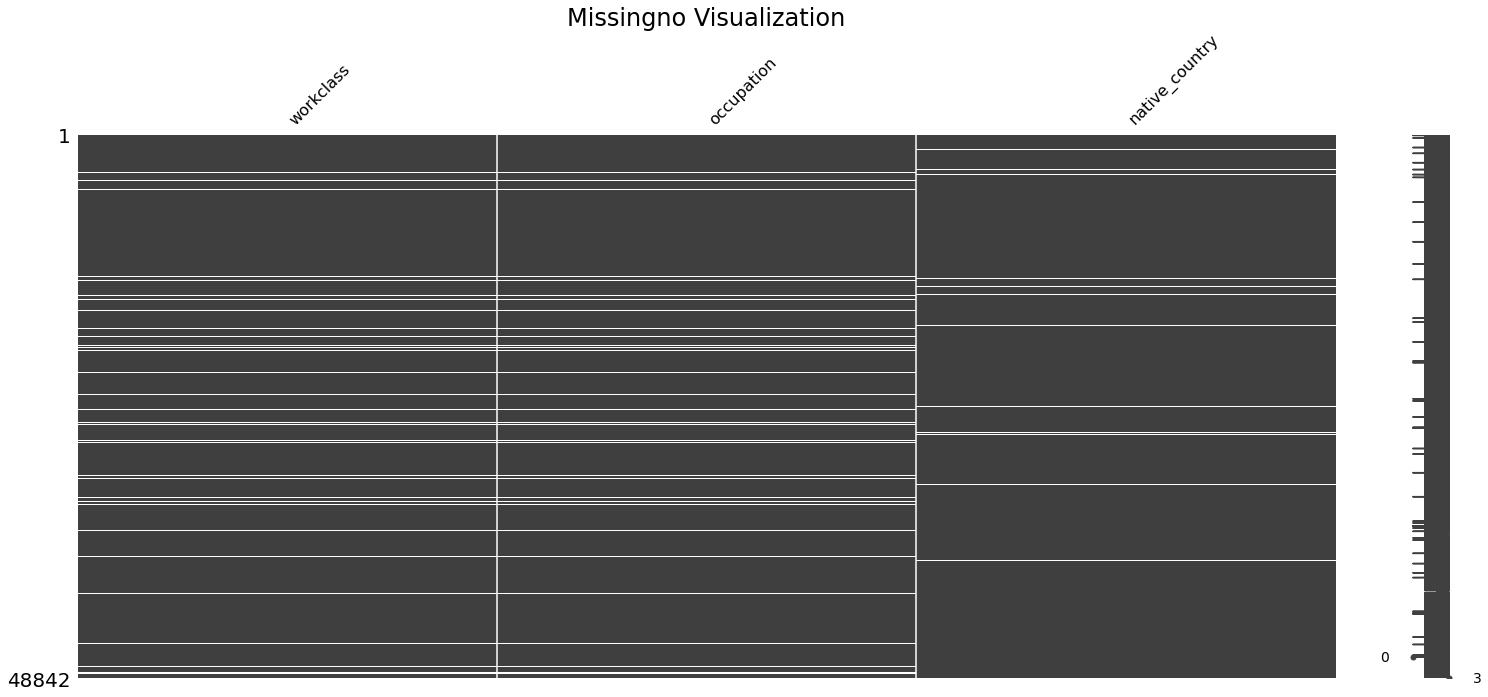

Text(0.5, 1.0, 'Missingno Visualization')

In [ ]:
msno.matrix(income_pd[['workclass' , 'occupation', 'native_country']])
plt.title('Missingno Visualization', fontsize=24)

**<h3><font style='color:#d26523'>Outcome<font></h1>**

As by first interpretation, these two columns have missing value  at the same corresponding rows. Whoever has missing value on occupation variable, has missing value on workclass.

<hr>
__I will apply imputer with the approach of most_frequent on the missing values in the following sections__

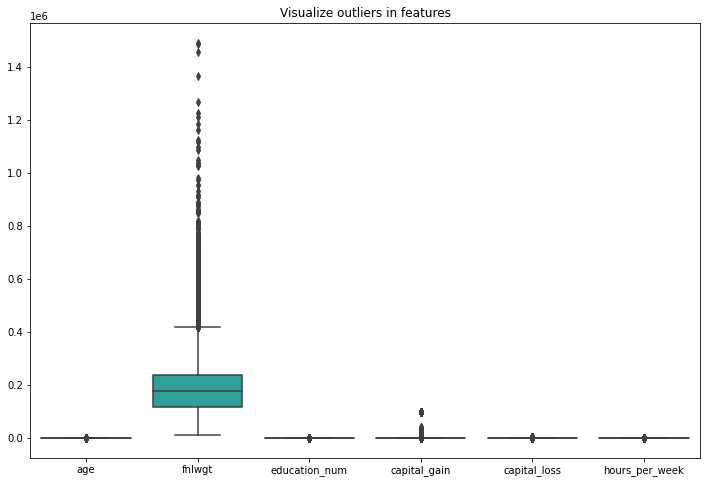

In [ ]:
figure, axes = plt.subplots(figsize=(12, 8))

ax = sns.boxplot(
  data = income_pd[NUMERICAL_FEATURES],
  color='lightseagreen',
)
ax.set_title("Visualize outliers in features")
plt.show()

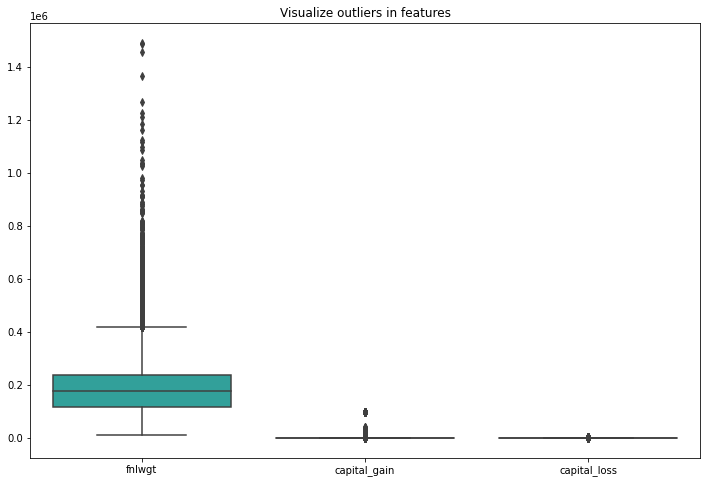

In [ ]:
figure, axes = plt.subplots(figsize=(12, 8))

ax = sns.boxplot(
  data = income_pd[['fnlwgt' ,'capital_gain' , 'capital_loss']],
  color='lightseagreen',
)
ax.set_title("Visualize outliers in features")
plt.show()

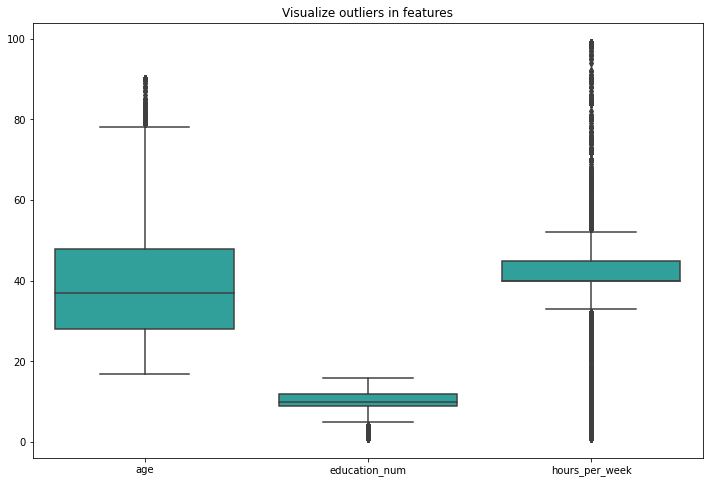

In [ ]:
figure, axes = plt.subplots(figsize=(12, 8))

ax = sns.boxplot(
  data = income_pd[['age', 'education_num'  , 'hours_per_week']],
  color='lightseagreen',
)
ax.set_title("Visualize outliers in features")
plt.show()

**<h3><font style='color:#d26523'>Observations<font></h1>**

As it can be seen in the above figures there are a many outliers in the numerical features. <hr/>
Since they were in different scales, outliers could not be seen in the first figures. This was the resoun I plot 3 different boxplot in order to visualize the ourliers

### Age Variable
Let's visualise the distribtion plot of the age variable.

Out[77]:

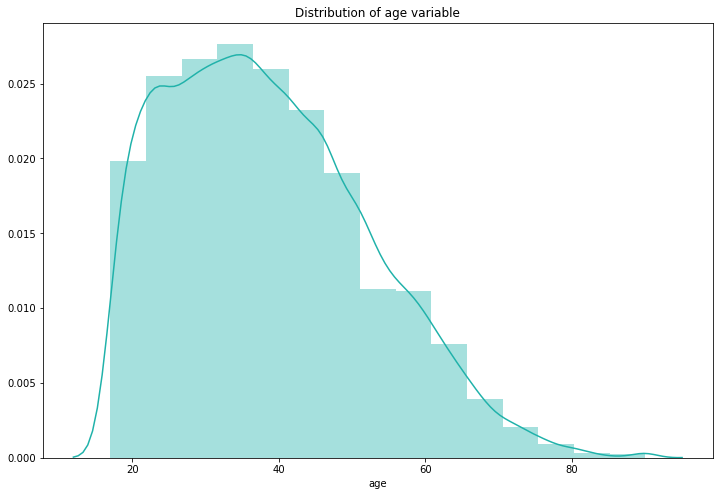

Text(0.5, 1.0, 'Distribution of age variable')

In [ ]:
figure, axes = plt.subplots(figsize=(12, 8))

ax = sns.distplot(
  income_pd['age'],
  color='lightseagreen',
  bins=15
)
ax.set_title("Distribution of age variable")

**<h3><font style='color:#d26523'>Observation<font></h1>**

As you can see the distribution of the age is positively skewed. <br/>
`fnlwgt` has the same behaviour.
<hr />
`skewness` is the measure of how much the probability distribution of a random variable deviates from the normal distribution. The normal distribution is the probability distribution without any skewness.
   You can look at the image below which shows symmetrical distribution that’s basically a normal distribution and you can see that it is symmetrical on both sides of the dashed line. Apart from this, there are two types of skewness:

<html>
  <head></head>
  <body>
    <div>
      <img width='800px' src="https://raw.githubusercontent.com/hasanteymoori/bdc-project/master/skewness.jpg">
    </div>
    
    <a href='https://corporatefinanceinstitute.com/resources/knowledge/other/skewness/'>What is Skewness?[reference]</a>
  </body>
</html>

<h4> Outliers in age variable </h4>

Many machine learning algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the training process of machine learning algorithms resulting in longer training times, less accurate models and ultimately poorer results.
<hr>
Visualise the __outliers__ in `age` variable with boxplot.

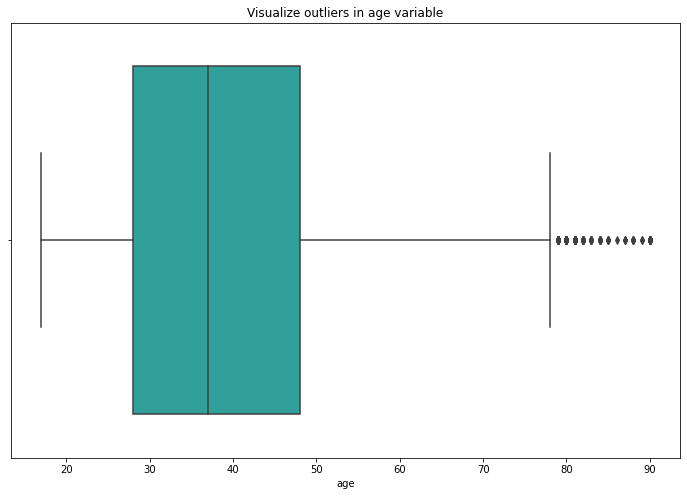

In [ ]:
figure, axes = plt.subplots(figsize=(12, 8))

ax = sns.boxplot(
  income_pd['age'],
  color='lightseagreen',
)
ax.set_title("Visualize outliers in age variable")
plt.show()

# 3. Learning & Feature Engineering


<div>
  <h4>Feature Engineering</h4>
   Feature engineering refers to a process of selecting and transforming variables in your dataset when creating a predictive model using machine learning.
</div>
<div>
  Therefore you have to extract the features from the __raw dataset__ you have collected before training your data in machine learning algorithms. Otherwise, it will be hard to gain good insights in your data.
</div>
<hr/>
<h4>The Learning Pipeline</h4>
A machine learning pipeline is a way to automate the workflow it takes to produce a machine learning model. Machine learning pipelines consist of multiple sequential steps that do everything from data extraction and preprocessing to model training and deployment.

<hr />

<div>
  <h3 style='color:#20b1c1'> My approach </h3>
  <p>For any machine learning task, testing is an important phase so as to realize how good our predictive task is. As I do not have any testing dataset I need to use some dataset entries to perform a evaluation task. </p>
  <p> The way in which I use different methods to train my model is in the following: </p>
  <ul>
    <h4>For __Logistic Regression__</h4><hr/>
    <li>Train a model using training set</li>
    <li>Analyse the model performance on `training set`</li>
    <li>Analyse the model performance on `test set`</li>
    <li>perform __hyperparameter tuning__ to find the best model using different paragemters</li>
    <li>Analyse the `best model` outcome of hp-tuning method and cross_validation on training set</li>
    <li>Analyse the `best model` outcome of hp-tuning method and cross_validation on test set</li> 
  </ul>
  <hr/>
  <p style='color:#228fb1'> For the rest of methods I will apply only the cross_validation and HP-tuning only</p>
</div>

**<h3><font style='color:#d26523'>Data Exploration Summary<font></h1>**

Summary of the critical findings from Data Exploration. Let's summarize the most important finding from my data analysis exploration, where we were able to observe the following:
- __Missing Data: there are 3 columns which contain missing values__;
- Unbalanced dataset. my dataset is not well-balanced;
- There are many categorical features needed to be encoded;
- Different scales of feature values;
- Several outliers on the some variables;
- Skewness on the age, fnlwgt variables;

### Imputation

Since our categorical features contains missing values and many methods in machine learning do not support dataset with missing values, I need to handle them before training a model.

In [ ]:
# from pyspark.ml import Pipeline
# # impute missing categorical variables with most frequent value
# from pyspark.ml.feature import Imputer

# def imputer(dataframe, missing_features):

#     """
#     Args:
#         - dataframe: original dataframe
#         - missing_features: the list of column names in `df` corresponding to the features which contains missing values

#     Return:
#         - df_imputed: the dataframe imputed according to the pipeline
#         - columns_imputed: the list of the imputed columns
#     """

#     # 1. Transfer a string column of labels to a column of label indices 
#     indexers, column_names_indexed = indexer(missing_features)
        
#     # 2. imputer
#     imputers = []
#     columns_imputed = []
#     for i in indexers:
#       column_name = "{0}_imputed".format(i.getOutputCol())
#       imputer = Imputer(inputCol=i.getOutputCol(), outputCol=column_name).setStrategy("mode")
#       imputers.append(imputer)
#       columns_imputed.append(column_name)

#     # 3. Setup the pipeline with the above processes
#     pipeline = Pipeline(stages=indexers + imputers)

#     # 4. Transform the input dataframe accordingly
#     transformer = pipeline.fit(dataframe)
#     df_imputed = transformer.transform(dataframe)

#     # 6. Eventually, return both the transformed dataframe and the transformer object for future transformations
#     return df_imputed, columns_imputed

**<h3><font style='color:#d26523'>Notes<font></h1>**

  Imputer is the imputation estimator for completing missing values, using the mean, median or mode of the columns in which the missing values are located. The input columns should be of numeric type. 
  __Currently Imputer does not support categorical features and possibly creates incorrect values for a categorical feature__
  
[source](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html)
  
<hr />
  To use the imputer I needed to index the categorical feature using string indexer. And evrything worked but since in the learning pipline I have to follow the same pipline, I decided to make it simple without taking the advantage of the imputer estimator as it does not support categorical features. So the way in which I handle the missing values is in the following.

In [ ]:
# Define a constant for columns which contains missing values
MISSING_FEATURES = [
  "workclass", "occupation", "native_country"
]

for column in MISSING_FEATURES:
  most_frequent = countview(income_dataframe, column, toPandas=False).collect()[0][column]
  
  income_dataframe = income_dataframe.withColumn(
    column, when(col(column).isNull() , most_frequent).otherwise(income_dataframe[column])
  )
  
# update the new version of the pandas dataframe
income_pd = income_dataframe.toPandas()

missing_values(income_dataframe.columns)


Number of missing values in column `age` = 0
Number of missing values in column `workclass` = 0
Number of missing values in column `fnlwgt` = 0
Number of missing values in column `education` = 0
Number of missing values in column `education_num` = 0
Number of missing values in column `marital_status` = 0
Number of missing values in column `occupation` = 0
Number of missing values in column `relationship` = 0
Number of missing values in column `race` = 0
Number of missing values in column `sex` = 0
Number of missing values in column `capital_gain` = 0
Number of missing values in column `capital_loss` = 0
Number of missing values in column `hours_per_week` = 0
Number of missing values in column `native_country` = 0
Number of missing values in column `income` = 0

**<h3><font style='color:#d26523'>Data Exploration Summary<font></h1>**

Summary of the critical findings from Data Exploration. Let's summarize the most important finding from my data analysis exploration, where we were able to observe the following:
  - Missing Data: there are 3 columns which contain missing values; <font style='color:#4e8803'><b>(DONE)</b></font>
  - __Unbalanced dataset. my dataset is not well-balanced__;
  - There are many categorical features needed to be encoded;
  - Different scales of feature values;
  - Several outliers on the some variables;
  - Skewness on the age, fnlwgt variables;

### Unbalanced Dataset

In simple terms, an unbalanced dataset is one in which the target variable (income) has more observations in one specific class ('<=50K') than the other ('>50K').<br>
Since we have a binary target variable (2 classes) — 0 when the person does not make more than 50K  and 1 when he/she makes more than 50K money — It’s normal that fact that less observations are belong to class 1 (over 50K) than to class 0 (below 50K). In this case, we have a unbalanced dataset.
<hr />

__Note__:
Most often, we have to deal with (very) unbalanced datasets where the minority class (which is usually the one we are interested in!) is accounting only for a small fraction of the total number of training instances. my dataset is not very unbalanced but making it to be balanced is a good way to make sure the outcome is reliable. 

The fact that a dataset is balanced (respectively, unbalanced) affects the process which we should use to correctly splitting it into _training_ and _test_ set.

After making the dataset balanced, we can safely use a <font style='color:red'><b>simple random sampling</b></font> strategy. 

<hr />

I will also use the original dataset and balanced dataset separately.

In [ ]:
target_pdf = countview(income_dataframe, TARGET_VARIABLE)
target_pdf.head()

Out[83]:

,income,count,percentage_of_each_value
0,<=50K,37155,76.07
1,>50K,11687,23.93


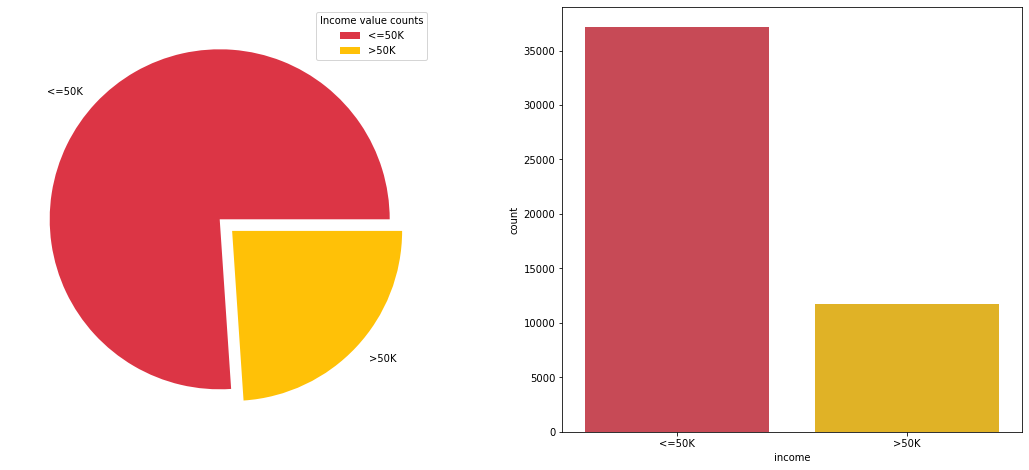

In [ ]:
# Plot the distribution of values of each column of interest
fig, axes = plt.subplots(1, 2, figsize=(16,8))

axes[0].pie(
  target_pdf['count'],
  colors = [COLOR_DANGER, COLOR_WARNING] ,
  labels = target_pdf[TARGET_VARIABLE], 
  explode=(0, 0.1)
)

sns.countplot(
  x=TARGET_VARIABLE, # y='income' # showing in y axes
  data=income_pd,
  palette = [COLOR_DANGER, COLOR_WARNING],
  ax=axes[1]
)

axes[0].legend(title = "Income value counts")
figure.show() 
fig.tight_layout(pad=6)

### Downsample Dataframe

my first approach would be downsampling the majority class w.r.t minority class in order to make them well-balanced.
The idea is to reduce the ratio of instances in the majority and minority levels. I can randomly select observations in the desired ratio — my approach is to make it __50/50__

In [ ]:
major_df = income_dataframe.filter(col(TARGET_VARIABLE) == '<=50K')
minor_df = income_dataframe.filter(col(TARGET_VARIABLE) == '>50K')
ratio = float(major_df.count()/minor_df.count())

print("ratio: {}".format(ratio))

ratio: 3.179173440574998


In [ ]:
sampled_majority_df = major_df.sample(False, 1/ratio)
down_sampled_df = sampled_majority_df.unionAll(minor_df)

**<h3><font style='color:gray'>Verify DataFrame is Balanced<font></h1>**<br>
Let's see the result of down-sampling

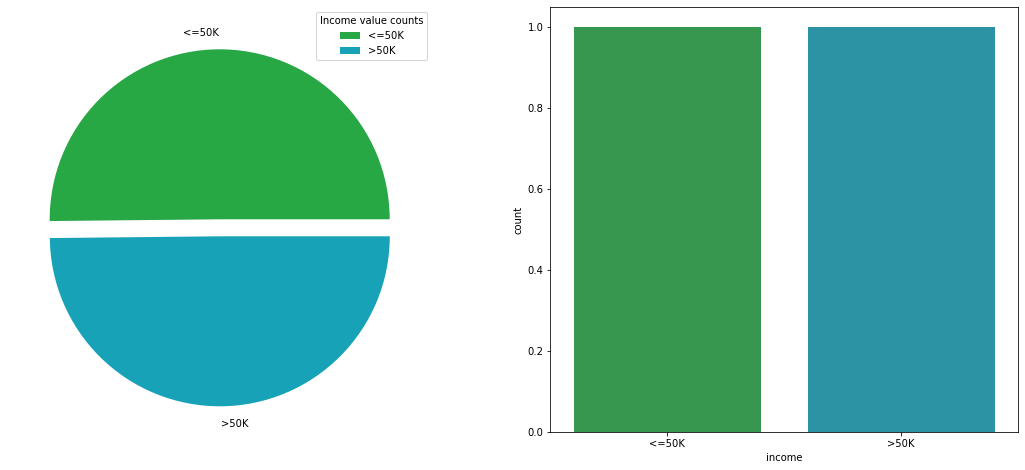

In [ ]:
# Plot the distribution of values of each column of interest
fig, axes = plt.subplots(1, 2, figsize=(16,8))

target_pdf = countview(down_sampled_df, TARGET_VARIABLE)

axes[0].pie(
  target_pdf['count'],
  colors = [COLOR_SUCCESS, COLOR_INFO] ,
  labels = target_pdf[TARGET_VARIABLE], 
  explode=(0, 0.1)
)

sns.countplot(
  x=TARGET_VARIABLE, # y='income' # showing in y axes
  data=target_pdf,
  palette = [COLOR_SUCCESS, COLOR_INFO],
  ax=axes[1]
)

axes[0].legend(title = "Income value counts")
figure.show() 
fig.tight_layout(pad=6)

### Dataset Splitting
Now, while I make the dataset well-balanced I could use random splitting approach safely to create Training Set and  Test Set.
- _train set_ ( **80%** of the total number of instances);
- _test set_  ( **20%** for the remaining of instances);

In [ ]:
RANDOM_SEED=42

# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_df, test_df = down_sampled_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
print("Training set size: {:d} instances".format(train_df.count()))
print("Test set size: {:d} instances".format(test_df.count()))

Training set size: 18755 instances
Test set size: 4557 instances


**<h3><font style='color:green'>Point to be considered<font></h1>**<br>
As mentioned above I will be working on the training set portion only (I don't have any testing dataset separatly). The test set will be used to evaluate our learned model.

**<h3><font style='color:#d26523'>Data Exploration Summary<font></h1>**

Summary of the critical findings from Data Exploration. Let's summarize the most important finding from my data analysis exploration, where we were able to observe the following:
  - Missing Data: there are 3 columns which contain missing values; <font style='color:#4e8803'><b>(DONE)</b></font>
  - Unbalanced dataset. my dataset is not well-balanced; <font style='color:#4e8803'><b>(DONE)</b></font>
  - __There are many categorical features needed to be encoded__;
  - Different scales of feature values;
  - Several outliers on the some variables;
  - Skewness on the age, fnlwgt variables;

### Handle Categorical Features

main approach is to transfer the categorical features into Numerical using One-Hot Encoding. 
<hr />
To transform _categorical_ features into _numerical_ I use following steps:
  - `StringIndexer`: encodes a string labels to label indices. (assigns the most frequent label the index 0, and so on).
  - `OneHotEncoderEstimator`: maps a categorical feature, represented as a label index (the outcome of previous step), to a binary one-hot-vector
  - `VectorAssembler`: combines a given list of columns into a single vector column.

<hr />
__Note that__ this step is not always mandatory (e.g., decision trees are able to work nicely with categorical features without the need of transforming them to numerical). Still, other methods (like logistic regression) are designed to operate with numerical inputs only. So we need a pipeline to perform nicely for all methods.

In [ ]:
from pyspark.ml.feature import StringIndexer

def indexer(inputCol, handleInvalid="keep"):
  """
    Args:
        - inputCol: columns to be indexed
        - handleInvalid: reserve a place for invalied values in the testing phase or production

    Return:
        - indexers: list of the indexers for each feature
        - names: list of the indexed features names
  """
  
  indexers = []
  column_names = []
  for column in inputCol:
      column_name = f"{column}_indexed"
      indexers.append(
        StringIndexer(inputCol=column, outputCol=column_name, handleInvalid="keep")
      )
      column_names.append(column_name)

  return indexers, column_names

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
  
def vectorizer(dataframe, numerical_features, categorical_features, target_variable):

    """
    Args:
        - dataframe: original dataframe
        - numerical_features: the list of column names in `df` corresponding to numerical features
        - categorical_features: the list of column names in `df` corresponding to categorical features
        - target_variable: the column name in `df` corresponding to the target variable

    Return:
        - transformer: the pipeline of transformation fit to `df` (for future usage)
        - df_transformed: the dataframe transformed according to the pipeline
    """
    
    # 1. Transfer a string column of labels to a column of label indices 
    # 1.1 Create a list of indexers, i.e., one for each categorical feature
    indexers, column_names_indexed = indexer(categorical_features)
    
    # 1.2 Indexing the target column => income (transform it into 0/1 since it is binary) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label(in this case income with <=50K)
    target_indexer = StringIndexer(inputCol=target_variable, outputCol='label')
    
    # 2. Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    output_columns = []
    for i in indexers:
      output_columns.append(f"{i.getOutputCol()}_encoded")
    encoder = OneHotEncoder(inputCols= column_names_indexed, outputCols=output_columns, handleInvalid="keep")
    
    # 3. Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    # 4. Setup the pipeline with the above processes
    pipeline = Pipeline(stages=indexers + [target_indexer] + [encoder]  + [assembler])

    # 5. Transform the input dataframe accordingly
    transformer = pipeline.fit(dataframe)
    df_transformed = transformer.transform(dataframe)

    # 6. Eventually, return both the transformed dataframe and the transformer object for future transformations
    return transformer, df_transformed 

In [ ]:
# Transform the training set
transformer, train_df_transformed = vectorizer(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

# Show the result of numerical transformation
train_df_transformed.show(5, truncate=True)

+---+---------+------+---------+-------------+--------------+---------------+------------+-----+------+------------+------------+--------------+--------------+------+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+-----+-------------------------+-------------------------+--------------------+--------------------------+------------------------------+------------------------------+----------------------------+-------------------+--------------------+
|age|workclass|fnlwgt|education|education_num|marital_status|     occupation|relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|workclass_indexed|education_indexed|marital_status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native_country_indexed|label|education_indexed_encoded|workclass_indexed_encoded|race_indexed_encoded|occupation_indexed_encoded|native_country_indexed_encode

**<h3><font style='color:green'>Note<font></h1>**<br>
As you can above section is not really informative. My `train_df_transformed` is now contains __raw data__ as well as __features__. Let's select only the useful information in order to use it during the training phase. the rest of the information in the dataframe is not really useful for me.

In [ ]:
# Select `features` and `label` target variable only
train = train_df_transformed.select(["features", "label"])
train.show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                          |label|
+------------------------------------------------------------------------------------------------------------------+-----+
|(112,[2,17,26,45,51,56,63,65,106,107,108,110,111],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,170916.0,6.0,1602.0,40.0])|1.0  |
|(112,[2,15,26,45,51,56,62,65,106,107,108,111],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,175587.0,7.0,30.0])           |1.0  |
|(112,[2,19,26,38,51,56,62,65,106,107,108,111],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,192387.0,5.0,45.0])           |1.0  |
|(112,[2,15,26,35,51,56,62,65,106,107,108,111],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,195262.0,7.0,35.0])           |1.0  |
|(112,[0,15,26,38,51,57,63,65,106,107,108,111],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,19752.0,7.0,25.0])            |1.0  |
+---------------

## Logistic Regression

As I said my approach would be to  first train a logistic regression model, using the training set which now pass the desired feature engineering pipline.To do so, I use the `LogisticRegression` object provided by the `PySpark API` ## Logistic Regression

In particular __Limited-memory BFGS__ (L-BFGS)<br>
As I said my approach would be to  first train a logistic regression model, using the training set which now pass the desired feature engineering pipline.To do so, I use the `LogisticRegression` object provided by the `PySpark API` within the package `pyspark.ml.classification` excatly to what we have seen in the class.

<hr />
In particular, we can specify the following parameters:

- `regParam`: The regularization parameter => lambda (ƛ);
- `elasticNetParam`: The tradeoff parameter for regularization penalties => alpha (⍺);

The optimal values of these parameters will be addressed during the hyperparametertuning.

In [ ]:
# This corresponds to LogisticRegressionWithLBFGS
from pyspark.ml.classification import LogisticRegression 

# No regularization (both alpha=0 and lambda=0)
Logistic_regression = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)
Logistic_regression_model = Logistic_regression.fit(train)

#### Performance: Training Set
In this section I am going to summarize the different evaluation metrics on the training set using trained logistic regression model.

In [ ]:
def summary(model):
  print('\033[1m_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________\u001b[0m')
  
  print('|   ')
  print(f'|   \u001b[36mThe Metrics are related to the Training Set \u001b[0m')
  print(f'|   \u001b[33mOur labels are :  => ["<=50K":{model.summary.labels[0]} , ">50K":{model.summary.labels[1]}] \u001b[0m')
  
  print('|   ')
  print(f'|   Precision forEach label: {model.summary.precisionByLabel}')
  print(f'|   Recall forEach label: {model.summary.recallByLabel}')
    
  print('|   ')
  print('|\u001b[1m   AUC:       {:.3f}'.format(model.summary.areaUnderROC))
  print('|   Accuracy:  {:.3f}'.format(model.summary.accuracy))
  
  print('|   ')
  print('|   Weighted Precision:   {:.3f}'.format(model.summary.weightedPrecision))
  print('|   Weighted Recall:      {:.3f}'.format(model.summary.weightedRecall))
  print('|   Weighted F1-Score:    {:.3f}'.format(model.summary.weightedFMeasure(beta=1.0)), '\u001b[0m')
  
  print('\033[1m__________________________________________________   End Of Summary   ___________________________________________________\n\u001b[0m')


In [ ]:
summary(Logistic_regression_model)

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Training Set 
 Our labels are : => ["<=50K":0.0 , ">50K":1.0] 
 
 Precision forEach label: [0.8432594901480575, 0.8069607446377984]
 Recall forEach label: [0.798797848782031, 0.8499573742540495]
 
 AUC: 0.909
 Accuracy: 0.824
 
 Weighted Precision: 0.825
 Weighted Recall: 0.824
 Weighted F1-Score: 0.824 
 __________________________________________________ End Of Summary ___________________________________________________

#### Evaluation Figures

**<h4><font style='color:green'>Precision-Recall<font></h1>**<br>
The precision-recall curve shows the tradeoff between precision and recall for different threshold. 
A high area under the curve represents both high recall and high precision, where high precision relates to a __low FPR__, and high recall relates to a __low FNR__.

- Precision = TruePositives / (TruePositives + FalsePositives)
- Recall    = TruePositives / (TruePositives + FalseNegatives)

Out[117]:

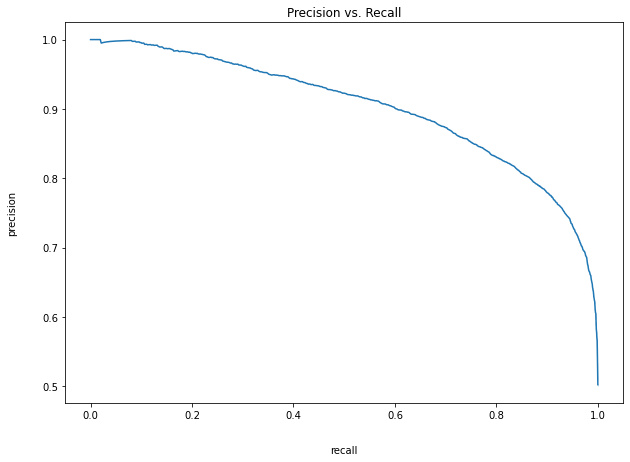

<matplotlib.axes._subplots.AxesSubplot at 0x7f7f4c7ce280>

In [ ]:
precision_recall = Logistic_regression_model.summary.pr.toPandas()

figure, axes = plt.subplots(figsize=(10, 7))

axes.set_xlabel("Recall", labelpad=25)
axes.set_ylabel("Precision", labelpad=25)
axes.set_title("Precision vs. Recall")

sns.lineplot(
  x=precision_recall['recall'],
  y=precision_recall['precision'],
)

**<h4><font style='color:green'>ROC Curve<font></h1>**<br>
which stand for Receiver-Operating Characteristic (ROC). <br />
A ROC curve is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate.

Out[118]:

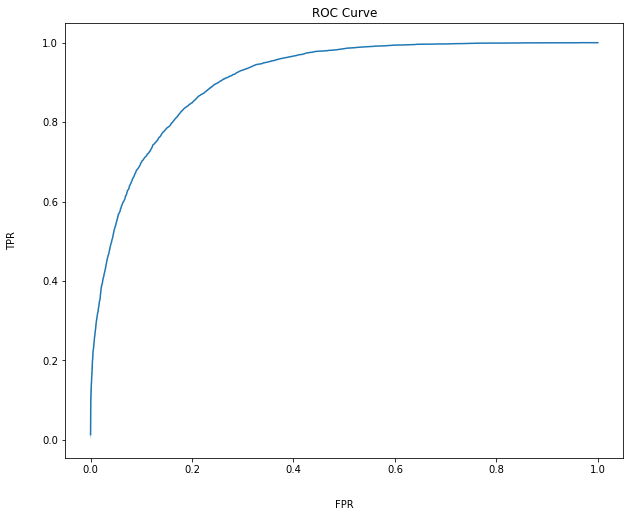

<matplotlib.axes._subplots.AxesSubplot at 0x7f7f4c7df0d0>

In [ ]:
ROC = Logistic_regression_model.summary.roc.toPandas()

figure, axes = plt.subplots(figsize=(10, 8))

axes.set_xlabel("False Positive Rate", labelpad=25)
axes.set_ylabel("True Positive Rate", labelpad=25)
axes.set_title("ROC Curve")

sns.lineplot(
  x=ROC['FPR'],
  y=ROC['TPR'],
)

#### Transform: Test Set

In this section I am going to use the One-Hot encoding pipeline (outcome of the vectorizer function) to transform the Test Set and evaluate how generalize our trained model by logistic regression is.

In [ ]:
# the same transformer returned by the `vectorizer` function and applied to the test set
test_df_transformed = transformer.transform(test_df)

test_df_transformed.show(5)

+---+---------+------+---------+-------------+--------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+-----+-------------------------+-------------------------+--------------------+--------------------------+------------------------------+------------------------------+----------------------------+-------------------+--------------------+
age|workclass|fnlwgt|education|education_num|marital_status| occupation|relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|workclass_indexed|education_indexed|marital_status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native_country_indexed|label|education_indexed_encoded|workclass_indexed_encoded|race_indexed_encoded|occupation_indexed_encoded|native_country_indexed_encoded|marital_status_indexed_encoded|relationship_indexed_encoded|sex_indexed_encoded| features|
+---+---------+------+---------+-------------+--------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+-----+-------------------------+-------------------------+--------------------+--------------------------+------------------------------+------------------------------+----------------------------+-------------------+--------------------+
 17|Local-gov|244856| 11th| 7| Never-married|Prof-specialty| Own-child|White|Female| 0| 0| 40| United-States| <=50K| 2.0| 7.0| 1.0| 0.0| 2.0| 0.0| 1.0| 0.0| 0.0| (17,[7],[1.0])| (8,[2],[1.0])| (6,[0],[1.0])| (15,[0],[1.0])| (42,[0],[1.0])| (8,[1],[1.0])| (7,[2],[1.0])| (3,[1],[1.0])|(112,[2,15,26,33,...|
 17| Private| 25690| 10th| 6| Never-married| Other-service| Own-child|White|Female| 0| 0| 10| United-States| <=50K| 0.0| 9.0| 1.0| 5.0| 2.0| 0.0| 1.0| 0.0| 0.0| (17,[9],[1.0])| (8,[0],[1.0])| (6,[0],[1.0])| (15,[5],[1.0])| (42,[0],[1.0])| (8,[1],[1.0])| (7,[2],[1.0])| (3,[1],[1.0])|(112,[0,17,26,38,...|
 17| Private| 32763| 10th| 6| Never-married| Other-service| Own-child|White| Male| 0| 0| 15| United-States| <=50K| 0.0| 9.0| 1.0| 5.0| 2.0| 0.0| 0.0| 0.0| 0.0| (17,[9],[1.0])| (8,[0],[1.0])| (6,[0],[1.0])| (15,[5],[1.0])| (42,[0],[1.0])| (8,[1],[1.0])| (7,[2],[1.0])| (3,[0],[1.0])|(112,[0,17,26,38,...|
 17| Private| 46402| 7th-8th| 4| Never-married| Sales| Own-child|White| Male| 0| 0| 8| United-States| <=50K| 0.0| 10.0| 1.0| 3.0| 2.0| 0.0| 0.0| 0.0| 0.0| (17,[10],[1.0])| (8,[0],[1.0])| (6,[0],[1.0])| (15,[3],[1.0])| (42,[0],[1.0])| (8,[1],[1.0])| (7,[2],[1.0])| (3,[0],[1.0])|(112,[0,18,26,36,...|
 17| Private| 52967| 10th| 6| Never-married| Other-service| Own-child|White|Female| 0| 0| 6| United-States| <=50K| 0.0| 9.0| 1.0| 5.0| 2.0| 0.0| 1.0| 0.0| 0.0| (17,[9],[1.0])| (8,[0],[1.0])| (6,[0],[1.0])| (15,[5],[1.0])| (42,[0],[1.0])| (8,[1],[1.0])| (7,[2],[1.0])| (3,[1],[1.0])|(112,[0,17,26,38,...|
+---+---------+------+---------+-------------+--------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+-----+-------------------------+-------------------------+--------------------+--------------------------+------------------------------+------------------------------+----------------------------+-------------------+--------------------+
only showing top 5 rows

**<h3><font style='color:#bd7f0d'>Note<font></h1>**<br>
As you can see, the above section is not really informative. My `test_df_transformed` is now contains __raw data__ as well as __features__. Let's select only the useful information in order to use it during the test phase. the rest of the information in the dataframe is not really useful for me, Just like training set.

In [ ]:
# Select `features` and `label` only
test = test_df_transformed.select(["features", "label"])
test.show(5)

+--------------------+-----+
 features|label|
+--------------------+-----+
(112,[2,15,26,33,...| 0.0|
(112,[0,17,26,38,...| 0.0|
(112,[0,17,26,38,...| 0.0|
(112,[0,18,26,36,...| 0.0|
(112,[0,17,26,38,...| 0.0|
+--------------------+-----+
only showing top 5 rows

**<h3><font style='color:#bd7f0d'>Predictions<font></h1>**<br>
In this section I use the trained model during the training phase to transform the test set. the out come will be our predictions. I will use this outcome to evaluate the performance of the trained model.

In [ ]:
# `log_reg_model` is a Transformer which can be used to "transform" our test set
predictions = Logistic_regression_model.transform(test)

#### Performance: Test Set
In this section I am going to summarize the different evaluation metrics on the test set using trained logistic regression model during the training phase.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  
  
def summary_test(predictions):
  evaluator =  BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderROC")
  evaluator2=  MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction")
  
  print('\033[1m_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________\u001b[0m')
  print('|   ')
  print(f'|   \u001b[36mThe Metrics are related to the Test Set \u001b[0m')
    
  print('|   ')
  print('|\u001b[1m   AUC:    {:.3f}'.format(evaluator.evaluate(predictions)))
  print('|   AreaUnder PR: {:.3f}'.format(evaluator.setMetricName("areaUnderPR").evaluate(predictions)))
  print('|   Accuracy:     {:.3f}'.format(evaluator2.setMetricName("accuracy").evaluate(predictions)))
  
  print('|   ')
  print('|   Weighted Precision:   {:.3f}'.format(evaluator2.setMetricName("weightedPrecision").evaluate(predictions)))
  print('|   Weighted Recall:      {:.3f}'.format(evaluator2.setMetricName("weightedRecall").evaluate(predictions)))
  print('|   Weighted  F1-Score:   {:.3f}'.format(evaluator2.setMetricName("f1").evaluate(predictions)), '\u001b[0m')
  
  print('\033[1m__________________________________________________   End Of Summary   ___________________________________________________\n\u001b[0m')


In [ ]:
summary_test(predictions)

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Test Set 
 
 AUC: 0.900
 AreaUnder PR: 0.893
 Accuracy: 0.814
 
 Weighted Precision: 0.816
 Weighted Recall: 0.814
 Weighted F1-Score: 0.814 
 __________________________________________________ End Of Summary ___________________________________________________

**<h3><font style='color:#bd7f0d'>Observation<font></h1>**<br>
As it can be seen in the result, our model is not overfitted.

### Tuning Hyperparameters
In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. in order to apply the hyperparameter_tuning I create a full learning pipline in the following section.

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

def hyperparameters_tuning(model, 
                           train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           param_grid,
                           apply_scaler=False,
                           k_fold=5):

    # Configure a general hyperparameter tuning pipeline, which consists of the following stages: 
    # => convert categorical features to numerical ones
    # => create assembeler vector
    # => standardize feature values (optional)
    # => run the pipeline of the hp-tuning


    # 1.a Indexer
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # 1.b Encoder for the categorical feature
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Encoder for the target feature
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    # 2 Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [encoder] + [label_indexer] + [assembler]
    
    # 3. Create the StandardScaler
    if apply_scaler == True:
      scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=True, withMean=True)
      stages += [scaler]


    # 4. Add the model transformer to the pipeline stages
    stages += [model]

    # 5. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # 6. Apply cross validator
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # 7. Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LogisticRegression 

log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100) # Since scaler is not used

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.

# the regularization parameter or lambda(ƛ);
# The tradeoff for regularization penalties(⍺)

param_grid = ParamGridBuilder()\
  .addGrid(log_reg.regParam, [0.0, 0.05, 0.1, 0.5 , 1]) \
  .addGrid(log_reg.maxIter, [10, 50, 100]) \
  .addGrid(log_reg.fitIntercept, [False, True])\
  .addGrid(log_reg.elasticNetParam, [0.0, 0.25, 0.5, 0.75 ,1.0]) \
  .build()
 
  # regParam = 0                        => No regularization;
  # regParam > 0 & elasticNetParam = 0  => Only L2-regularization; 
  # regParam > 0 & elasticNetParam = 1  => Only L1-regularization;
  
cv_model = hyperparameters_tuning(
  log_reg,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m________________***   Summary Of Models Setting: Logistic Regression   ***________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Logistic Regression \u001b[0m\n')

for fold, models in enumerate(cv_model.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    regParam        = m.stages[-1].getRegParam()        # [0.0, 0.05, 0.1, 0.5 , 1]
    maxIter         = m.stages[-1].getMaxIter()         # [10, 50, 100, 110]
    fitIntercept    = m.stages[-1].getFitIntercept()    # [False, True]
    elasticNetParam = m.stages[-1].getElasticNetParam() # [0.0, 0.25, 0.5, 0.75 ,1.0]
    
    print(f'\tParameters: lambda=[{regParam}]; maxIter=[{maxIter}]; fitIntercept=[{fitIntercept}]; alpha=[{elasticNetParam}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model.avgMetrics[i]), '\u001b[0m')
  
  
  print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


________________*** Summary Of Models Setting: Logistic Regression ***________________ 

 The Summary is related to the Hyperparameter tuning for Logistic Regression 

 ======> Fold # 0 Summary: 

 ==> Model #1 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.0];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #2 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.25];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #3 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.5];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #4 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.75];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #5 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[1.0];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #6 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[True]; alpha=[0.0];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #7 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[True]; alpha=[0.25];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #8 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[True]; alpha=[0.5];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #9 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[True]; alpha=[0.75];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #10 out of 150 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[True]; alpha=[1.0];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.899
 
 ==> Model #11 out of 150 
	Parameters: lambda=[0.0]; maxIter=[50]; fitIntercept=[False]; alpha=[0.0];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.904
 
 ==> Model #12 out of 150 
	Parameters: lambda=[0.0]; maxIter=[50]; fitIntercept=[False]; alpha=[0.25];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.904
 
 ==> Model #13 out of 150 
	Parameters: lambda=[0.0]; maxIter=[50]; fitIntercept=[False]; alpha=[0.5];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.904
 
 ==> Model #14 out of 150 
	Parameters: lambda=[0.0]; maxIter=[50]; fitIntercept=[False]; alpha=[0.75];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.904
 
 ==> Model #15 out of 150 
	Parameters: lambda=[0.0]; maxIter=[50]; fitIntercept=[False]; alpha=[1.0];
 Model summary: LogisticRegressionModel: uid=LogisticRegression_6958430dbc6f, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.904
 
 ==> Model #16 out of 150 
	Parameters: lambda=[0.0]; maxIter=[50]; fitIntercept=[True]; alpha=[0.0];
 Model summary: LogisticRegressionModel: uid=Logi

In [ ]:
best_regParam        = cv_model.bestModel.stages[-1].getRegParam()
best_maxIter         = cv_model.bestModel.stages[-1].getMaxIter()
best_fitIntercept    = cv_model.bestModel.stages[-1].getFitIntercept()
best_elasticNetParam = cv_model.bestModel.stages[-1].getElasticNetParam()

print('\033[1m_____________________*****   Best Model: Logistic Regression   *****_____________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t lambda       : {best_regParam} \u001b[0m')
print(f'\033[1m\t\t maxIter      : {best_maxIter} \u001b[0m')
print(f'\033[1m\t\t fitIntercept : {fitIntercept} \u001b[0m')
print(f'\033[1m\t\t alpha        : {best_elasticNetParam} \u001b[0m\n')


_____________________*****   Best Model: Logistic Regression   *****_____________________

Best model according to k-fold cross validation has: 

		 lambda       : 0.0 
		 maxIter      : 50 
		 fitIntercept : True 
		 alpha        : 0.0 



**<h3><font style='color:#bd7f0d'>Best Model Performance: Training Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __training set__,  using the best resulting model according to k-fold cross validation on the previous section.
  
  <hr />
__Note__: `bestModel` is also entirely __retrained__ on the whole `train_df_transformed`

In [ ]:
# print("***** Training Set *****")
# print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result.areaUnderROC))
# print("***** Training Set *****")

summary(cv_model.bestModel.stages[-1])

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Training Set 
 Our labels are : => ["<=50K":0.0 , ">50K":1.0] 
 
 Precision forEach label: [0.8065464126469396, 0.8388738127544098]
 Recall forEach label: [0.8481457800511509, 0.7953473413379074]
 
 AUC: 0.907
 Accuracy: 0.822
 
 Weighted Precision: 0.823
 Weighted Recall: 0.822
 Weighted F1-Score: 0.822 
 __________________________________________________ End Of Summary ___________________________________________________

**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions = cv_model.transform(test_df)

test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(111,[2,16,26,38,...| 1.0| 1.0|
(111,[2,15,26,35,...| 1.0| 1.0|
(111,[2,15,26,33,...| 1.0| 1.0|
(111,[0,16,26,38,...| 1.0| 1.0|
(111,[0,16,26,43,...| 1.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions)

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Test Set 
 
 AUC: 0.901
 AreaUnder PR: 0.911
 Accuracy: 0.823
 
 Weighted Precision: 0.824
 Weighted Recall: 0.823
 Weighted F1-Score: 0.822 
 __________________________________________________ End Of Summary ___________________________________________________

## Decision Tree

I am going to  train a classification tree, using the training set only, like the logistic regression. Decision tree as d o not require feature scaling. So I would not apply the scaling in this case.

<hr />

Desicion Tree is implemented in `DecisionTreeClassifier` class provided by the package `pyspark.ml.classification`.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxBins=42, seed=21)

param_grid = ParamGridBuilder() \
    .addGrid(decision_tree.maxDepth, [3, 5, 8, 15, 18 ,20, 22 ,23, 24 ,25, 27 ,30]) \
    .addGrid(decision_tree.minInfoGain, [0.0, 0.1, 0.3]) \
    .addGrid(decision_tree.impurity, ["gini", "entropy"]) \
    .build()


cv_model_dt = hyperparameters_tuning(
  decision_tree,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m__________________***   Summary Of Models Setting: Decision Tree   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Decision Tree \u001b[0m\n')

for fold, models in enumerate(cv_model_dt.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')

  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    maxDepth        = m.stages[-1].getMaxDepth()         # [3, 5, 8, 15, 18 ,20, 22 ,23, 24 ,25, 27 ,30]
    minInfoGain     = m.stages[-1].getMinInfoGain()      # [0.0, 0.1, 0.3]
    impurity        = m.stages[-1].getImpurity()         # ["gini", "entropy"]
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; minInfoGain=[{minInfoGain}]; impurity=[{impurity}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_dt.avgMetrics[i]), '\u001b[0m')
  
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 

__________________***   Summary Of Models Setting: Decision Tree   ***__________________

The Summary is related to the Hyperparameter tuning for Decision Tree 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.0]; impurity=[gini];
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_34c2c856107f, depth=3, numNodes=7, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.781
 
 ==> Model #2 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.0]; impurity=[entropy];
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_34c2c856107f, depth=2, numNodes=5, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.756
 
 ==> Model #3 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.1]; impurity=[gini];
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_34c2c856107f, depth=1, numNodes=3, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.761
 
 ==> Model #4 out of 7

In [ ]:
best_maxDepth        = cv_model_dt.bestModel.stages[-1].getMaxDepth()
best_minInfoGain        = cv_model_dt.bestModel.stages[-1].getMinInfoGain()
best_impurity        = cv_model_dt.bestModel.stages[-1].getImpurity()

print('\033[1m__________________________*****   Best Model: Decision Tree   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t minInfoGain        : {best_minInfoGain} \u001b[0m')
print(f'\033[1m\t\t impurity        : {best_impurity} \u001b[0m')


__________________________*****   Best Model: Decision Tree   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 24 
		 minInfoGain        : 0.0 
		 impurity        : entropy 


In [ ]:
from pyspark.sql.functions import *

print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_dt.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.817


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_dt = cv_model_dt.transform(test_df)

test_predictions_dt.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(111,[2,15,26,37,...|       0.0|  0.0|
|(111,[0,15,26,38,...|       0.0|  0.0|
|(111,[0,16,26,36,...|       0.0|  0.0|
|(111,[0,16,26,33,...|       0.0|  0.0|
|(111,[0,16,26,33,...|       0.0|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_dt)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.839
|   AreaUnder PR: 0.856
|   Accuracy:     0.787
|   
|   Weighted Precision:   0.788
|   Weighted Recall:      0.787
|   Weighted  F1-Score:   0.787 
__________________________________________________   End Of Summary   ___________________________________________________



**<h3><font style='color:darkgreen'>Feature importance<font></h1>**<br>
Let's plot the feature importance to see which of the features are more important than the others

Out[52]: <matplotlib.axes._subplots.AxesSubplot at 0x7fa52c92ded0>

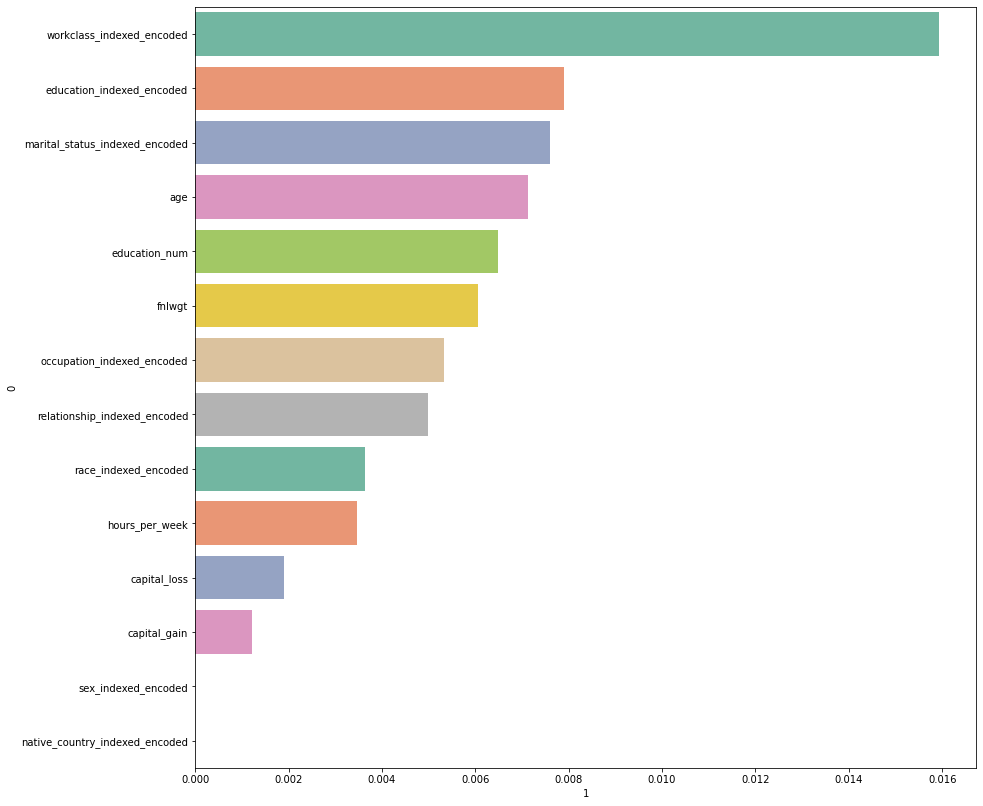

In [ ]:

fig, axes = plt.subplots(1, 1, figsize=(14,14))

importancy = pd.DataFrame(
    list(
        zip(cv_model_dt.bestModel.stages[-2].getInputCols(), cv_model_dt.bestModel.stages[-1].featureImportances)
    )
)

sns.barplot(
    x=1, 
    y=0, 
    palette="Set2", 
    data=importancy.sort_values(by=1, ascending = False)
)

**<h3><font style='color:#bd7f0d'>Observations<font></h3>**<br>
  - As expected `workclass`, `education`, `marital_status`, `age` and `occupation` are more important features regarding someone's income prediction.
<hr />
Base on the result, decision tree performed worst than logistic regression. Let's see what are the outcome for stronger decision tree methods, such as **Random Forests** (**RF**) and **Gradient Boosted Decision Trees** (**GBDT**).

## Random Forests

As I have seen in the previous section, one single decision tree perform poorly on my training set. The prediction accuracy of decision trees can be improved by ensemble methods, such as Random Forests (RF) and Gradient Boosted Decision Trees (GBDT). which in the following section I will check the performance of both methods.

<hr />

Random Forests is implemented in `RandomForestClassifier` class provided by the package `pyspark.ml.classification`.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder

random_forest = RandomForestClassifier(featuresCol="features", labelCol="label", maxBins=42, seed=21) 

# for maxDepth: 3, 5, 10, 12, 14 have also been tested, but the result are not good.
param_grid = ParamGridBuilder()\
    .addGrid(random_forest.maxDepth, [10, 15]) \
    .addGrid(random_forest.numTrees, [500, 1000]) \
    .build()


cv_model_rf = hyperparameters_tuning(
  random_forest,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

### Models & Best one
Let's first print all the models trained using different hyperparameters. 

__I could not apply the grid parameters at one shot! So I have created some smaller grids to reach the best random forest model__ you can see all of the results from different grids in the following 

<hr />
Note: Some of the values for grids may be similar, that's because many times the small cells failed. at first time I created 20 different small grids but only the following grids performed successfully. 

<hr />

The result are in order. 
  - first 4 cells are for the grid summary
  - second 4 cells are the best params for the corresponding cells
  - third 4 cells are the AUC Roc avg value for these documents __training set__
  - last 4 cells are related to the result on __test set__

In [ ]:
# ***************** Document for small Grid below. *********************************@

# maxDepth: [8, 12]
# impurity: ["gini"]
# NumTrees. [50, 100]

print('\033[1m__________________***   Summary Of Models Setting: Random Forest   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Random Forest \u001b[0m\n')

for fold, models in enumerate(cv_model_rf.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    numTrees        = m.stages[-1]._java_obj.getNumTrees()
    maxDepth        = m.stages[-1].getMaxDepth()
    impurity        = m.stages[-1].getImpurity()
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; impurity=[{impurity}]; numTrees=[{numTrees}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_rf.avgMetrics[i]), '\u001b[0m')
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


__________________***   Summary Of Models Setting: Random Forest   ***__________________

The Summary is related to the Hyperparameter tuning for Random Forest 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 4 
	Parameters: maxDepth=[8]; impurity=[gini]; numTrees=[50];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_6d918786eebf, numTrees=50, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.901
 
 ==> Model #2 out of 4 
	Parameters: maxDepth=[8]; impurity=[gini]; numTrees=[100];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_6d918786eebf, numTrees=100, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.901
 
 ==> Model #3 out of 4 
	Parameters: maxDepth=[12]; impurity=[gini]; numTrees=[50];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_6d918786eebf, numTrees=50, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.909
 
 ==> Model #4 out of 4 
	Parameters: maxDepth=[12]; impurity=

In [ ]:
# ***************** Document for small Grid below. *********************************@

# maxDepth: [8, 12, 14]
# impurity: ["gini"]
# NumTrees. [50, 100]

print('\033[1m__________________***   Summary Of Models Setting: Random Forest   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Random Forest \u001b[0m\n')

for fold, models in enumerate(cv_model_rf.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    numTrees        = m.stages[-1]._java_obj.getNumTrees()
    maxDepth        = m.stages[-1].getMaxDepth()       
    impurity        = m.stages[-1].getImpurity()        
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; impurity=[{impurity}]; numTrees=[{numTrees}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_rf.avgMetrics[i]), '\u001b[0m')
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


__________________***   Summary Of Models Setting: Random Forest   ***__________________

The Summary is related to the Hyperparameter tuning for Random Forest 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 6 
	Parameters: maxDepth=[8]; impurity=[gini]; numTrees=[50];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_3781f8617b27, numTrees=50, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.901
 
 ==> Model #2 out of 6 
	Parameters: maxDepth=[8]; impurity=[gini]; numTrees=[100];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_3781f8617b27, numTrees=100, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.901
 
 ==> Model #3 out of 6 
	Parameters: maxDepth=[12]; impurity=[gini]; numTrees=[50];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_3781f8617b27, numTrees=50, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.909
 
 ==> Model #4 out of 6 
	Parameters: maxDepth=[12]; impurity=

In [ ]:
# ***************** Document for small Grid bellow. *********************************@

# maxDepth: [8, 15]
# impurity: ["gini"]
# NumTrees. [50, 120]


print('\033[1m__________________***   Summary Of Models Setting: Random Forest   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Random Forest \u001b[0m\n')

for fold, models in enumerate(cv_model_rf.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    numTrees        = m.stages[-1]._java_obj.getNumTrees()
    maxDepth        = m.stages[-1].getMaxDepth()        
    impurity        = m.stages[-1].getImpurity()
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; impurity=[{impurity}]; numTrees=[{numTrees}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_rf.avgMetrics[i]), '\u001b[0m')
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


__________________***   Summary Of Models Setting: Random Forest   ***__________________

The Summary is related to the Hyperparameter tuning for Random Forest 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 4 
	Parameters: maxDepth=[8]; impurity=[gini]; numTrees=[50];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_3034fd1cf848, numTrees=50, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.901
 
 ==> Model #2 out of 4 
	Parameters: maxDepth=[8]; impurity=[gini]; numTrees=[120];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_3034fd1cf848, numTrees=120, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.901
 
 ==> Model #3 out of 4 
	Parameters: maxDepth=[15]; impurity=[gini]; numTrees=[50];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_3034fd1cf848, numTrees=50, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.912
 
 ==> Model #4 out of 4 
	Parameters: maxDepth=[15]; impurity=

In [ ]:
# ***************** Document for small Grid bellow. *********************************@

# maxDepth: [5, 10]
# impurity: ["gini"]
# NumTrees. [100, 150]

print('\033[1m__________________***   Summary Of Models Setting: Random Forest   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Random Forest \u001b[0m\n')

for fold, models in enumerate(cv_model_rf.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    numTrees        = m.stages[-1]._java_obj.getNumTrees()
    maxDepth        = m.stages[-1].getMaxDepth()  
    impurity        = m.stages[-1].getImpurity()      
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; impurity=[{impurity}]; numTrees=[{numTrees}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_rf.avgMetrics[i]), '\u001b[0m')
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


__________________***   Summary Of Models Setting: Random Forest   ***__________________

The Summary is related to the Hyperparameter tuning for Random Forest 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 4 
	Parameters: maxDepth=[5]; impurity=[gini]; numTrees=[100];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_6163d488bb15, numTrees=100, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.888
 
 ==> Model #2 out of 4 
	Parameters: maxDepth=[5]; impurity=[gini]; numTrees=[150];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_6163d488bb15, numTrees=150, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.888
 
 ==> Model #3 out of 4 
	Parameters: maxDepth=[10]; impurity=[gini]; numTrees=[100];
	Model summary: RandomForestClassificationModel: uid=RandomForestClassifier_6163d488bb15, numTrees=100, numClasses=2, numFeatures=111
	Avg. ROC AUC computed: 0.906
 
 ==> Model #4 out of 4 
	Parameters: maxDepth=[10]; impur

In [ ]:
best_maxDepth        = cv_model_rf.bestModel.stages[-1].getMaxDepth()
best_impurity        = cv_model_rf.bestModel.stages[-1].getImpurity()
best_numTrees        = cv_model_rf.bestModel.stages[-1]._java_obj.getNumTrees()

print('\033[1m__________________________*****   Best Model: Random Forest   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t impurity        : {best_impurity} \u001b[0m')
print(f'\033[1m\t\t numTrees        : {numTrees} \u001b[0m')


__________________________*****   Best Model: Random Forest   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 12 
		 impurity        : gini 
		 numTrees        : 100 


In [ ]:
best_maxDepth        = cv_model_rf.bestModel.stages[-1].getMaxDepth()
best_impurity        = cv_model_rf.bestModel.stages[-1].getImpurity()
best_numTrees        = cv_model_rf.bestModel.stages[-1]._java_obj.getNumTrees()

print('\033[1m__________________________*****   Best Model: Random Forest   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t impurity        : {best_impurity} \u001b[0m')
print(f'\033[1m\t\t numTrees        : {numTrees} \u001b[0m')


__________________________*****   Best Model: Random Forest   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 14 
		 impurity        : gini 
		 numTrees        : 100 


In [ ]:
best_maxDepth        = cv_model_rf.bestModel.stages[-1].getMaxDepth()
best_impurity        = cv_model_rf.bestModel.stages[-1].getImpurity()
best_numTrees        = cv_model_rf.bestModel.stages[-1]._java_obj.getNumTrees()

print('\033[1m__________________________*****   Best Model: Random Forest   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t impurity        : {best_impurity} \u001b[0m')
print(f'\033[1m\t\t numTrees        : {numTrees} \u001b[0m')


__________________________*****   Best Model: Random Forest   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 15 
		 impurity        : gini 
		 numTrees        : 120 


In [ ]:
best_maxDepth        = cv_model_rf.bestModel.stages[-1].getMaxDepth()
best_impurity        = cv_model_rf.bestModel.stages[-1].getImpurity()
best_numTrees        = cv_model_rf.bestModel.stages[-1]._java_obj.getNumTrees()

print('\033[1m__________________________*****   Best Model: Random Forest   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t impurity        : {best_impurity} \u001b[0m')
print(f'\033[1m\t\t numTrees        : {numTrees} \u001b[0m')


__________________________*****   Best Model: Random Forest   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 10 
		 impurity        : gini 
		 numTrees        : 120 


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_rf.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.909


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_rf.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.911


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_rf.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.912


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_rf.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.906


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_rf = cv_model_rf.transform(test_df)

test_predictions_rf.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(111,[7,16,26,47,...|       0.0|  0.0|
|(111,[7,16,26,47,...|       0.0|  0.0|
|(111,[7,16,26,47,...|       0.0|  0.0|
|(111,[7,15,26,47,...|       0.0|  0.0|
|(111,[7,15,26,47,...|       0.0|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_rf)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.917
|   AreaUnder PR: 0.913
|   Accuracy:     0.833
|   
|   Weighted Precision:   0.839
|   Weighted Recall:      0.833
|   Weighted  F1-Score:   0.832 
__________________________________________________   End Of Summary   ___________________________________________________



In [ ]:
summary_test(test_predictions_rf)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.918
|   AreaUnder PR: 0.915
|   Accuracy:     0.834
|   
|   Weighted Precision:   0.840
|   Weighted Recall:      0.834
|   Weighted  F1-Score:   0.834 
__________________________________________________   End Of Summary   ___________________________________________________



In [ ]:
summary_test(test_predictions_rf)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.919
|   AreaUnder PR: 0.915
|   Accuracy:     0.836
|   
|   Weighted Precision:   0.841
|   Weighted Recall:      0.836
|   Weighted  F1-Score:   0.835 
__________________________________________________   End Of Summary   ___________________________________________________



In [ ]:
summary_test(test_predictions_rf)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.914
|   AreaUnder PR: 0.909
|   Accuracy:     0.831
|   
|   Weighted Precision:   0.838
|   Weighted Recall:      0.831
|   Weighted  F1-Score:   0.830 
__________________________________________________   End Of Summary   ___________________________________________________



**<h3><font style='color:#bd7f0d'>Observations<font></h3>**<br>
Using Random Forest we are able to improve performance compare to the single decision tree!. I will also apply the GBDT later on.

It seems that so far the best method is Random Forest.

**<h3><font style='color:darkgreen'>Feature importance<font></h1>**<br>
Let's plot the feature importance to see which of the features are more important than the others like the decision tree but this time by using the rendom forest best model

Out[30]: <matplotlib.axes._subplots.AxesSubplot at 0x7fe43bafbd90>

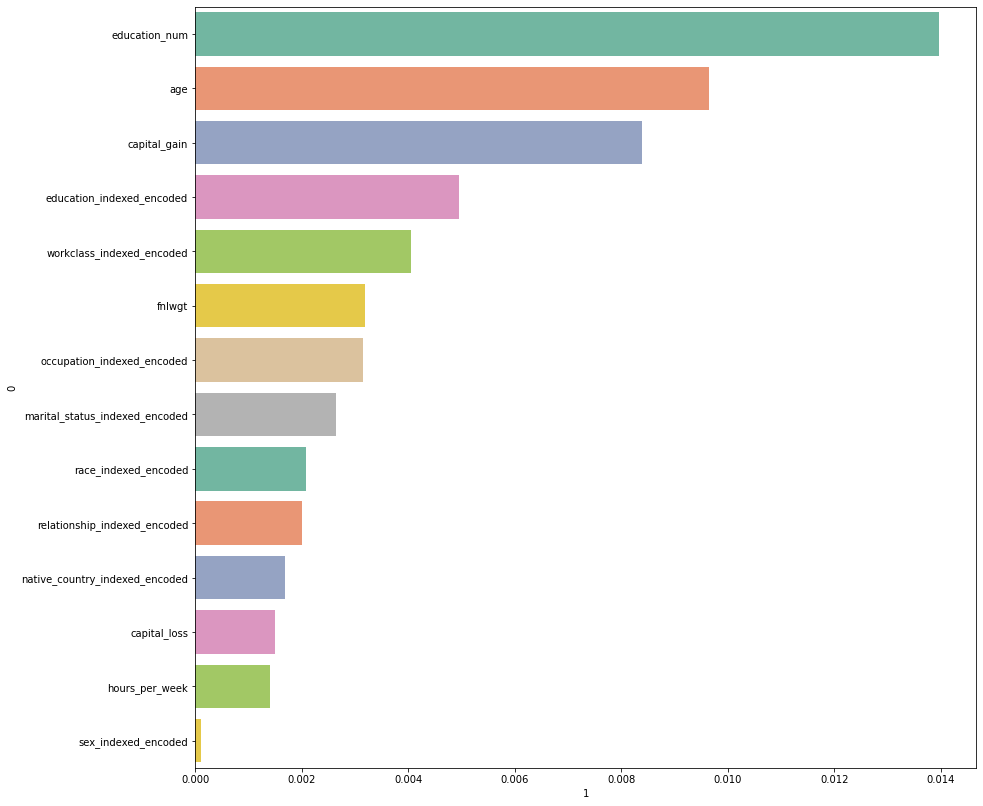

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14,14))

importancy_rf = pd.DataFrame(
    list(
        zip(cv_model_rf.bestModel.stages[-2].getInputCols(), cv_model_rf.bestModel.stages[-1].featureImportances)
    )
)

sns.barplot(
    x=1, 
    y=0, 
    palette="Set2", 
    data=importancy_rf.sort_values(by=1, ascending = False)
)

**<h3><font style='color:#bd7f0d'>Observations<font></h3>**<br>
  - As expected `workclass`, `education`, `marital_status`, `age` and `occupation` are more important features regarding someone's income prediction.
  - one thing to notice is that while decision tree was not able to introduce `capital_gain` as an important feature, random forest introduce it as a __Top-Three__ important feature which is reliable.
<hr />

## Gradient Boosted Decision Tree

This method is an ensemble of weak learners is used to improve the performance of a machine learning model. The weak learners are usually decision trees. Combined, their output results in better models. In gradient boosting, weak learners work sequentially. Each model tries to improve on the error from the previous model.

<hr />

GBDT is implemented in `GBTClassifier` class provided by the package `pyspark.ml.classification`.
<hr />
Like random forest I could not reach a good answer even with small grids, two of my small grids were able to reach a best model.

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbtr = GBTClassifier(featuresCol="features", labelCol="label", maxBins=42)

param_grid = ParamGridBuilder()\
    .addGrid(gbtr.maxDepth, [7]) \
    .addGrid(gbtr.maxIter, [60]) \
    .build()


cv_model_gbtr = hyperparameters_tuning(
  gbtr,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:


print('\033[1m__________________***   Summary Of Models Setting: Gradient Boosted DT   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Gradient Boosted DT \u001b[0m\n')

for fold, models in enumerate(cv_model_gbtr.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    maxDepth        = m.stages[-1].getMaxDepth() 
    maxIter        = m.stages[-1].getMaxIter()         
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; maxIter=[{maxIter}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_gbtr.avgMetrics[i]), '\u001b[0m')
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


__________________***   Summary Of Models Setting: Gradient Boosted DT   ***__________________

The Summary is related to the Hyperparameter tuning for Gradient Boosted DT 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 6 
	Parameters: maxDepth=[3]; maxIter=[10];
	Model summary: GBTClassificationModel: uid = GBTClassifier_93c3ba481025, numTrees=10, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.898
 
 ==> Model #2 out of 6 
	Parameters: maxDepth=[3]; maxIter=[50];
	Model summary: GBTClassificationModel: uid = GBTClassifier_93c3ba481025, numTrees=50, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.912
 
 ==> Model #3 out of 6 
	Parameters: maxDepth=[5]; maxIter=[10];
	Model summary: GBTClassificationModel: uid = GBTClassifier_93c3ba481025, numTrees=10, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.908
 
 ==> Model #4 out of 6 
	Parameters: maxDepth=[5]; maxIter=[50];
	Model summary: GBTClassificationModel: uid = GBTClassifier_93c3ba481025, numTrees=50, nu

In [ ]:
print('\033[1m__________________***   Summary Of Models Setting: Gradient Boosted DT   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Gradient Boosted DT \u001b[0m\n')

for fold, models in enumerate(cv_model_gbtr.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    maxDepth        = m.stages[-1].getMaxDepth()         # [3, 5, 8, 15, 18 ,20, 22 ,23, 25, 27 ,30]
    maxIter        = m.stages[-1].getMaxIter()         
    
    print(f'\tParameters: maxDepth=[{maxDepth}]; maxIter=[{maxIter}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_gbtr.avgMetrics[i]), '\u001b[0m')
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 


__________________***   Summary Of Models Setting: Gradient Boosted DT   ***__________________

The Summary is related to the Hyperparameter tuning for Gradient Boosted DT 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 4 
	Parameters: maxDepth=[10]; maxIter=[60];
	Model summary: GBTClassificationModel: uid = GBTClassifier_d6d732f0d633, numTrees=60, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.906
 
 ==> Model #2 out of 4 
	Parameters: maxDepth=[10]; maxIter=[80];
	Model summary: GBTClassificationModel: uid = GBTClassifier_d6d732f0d633, numTrees=80, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.905
 
 ==> Model #3 out of 4 
	Parameters: maxDepth=[12]; maxIter=[60];
	Model summary: GBTClassificationModel: uid = GBTClassifier_d6d732f0d633, numTrees=60, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.896
 
 ==> Model #4 out of 4 
	Parameters: maxDepth=[12]; maxIter=[80];
	Model summary: GBTClassificationModel: uid = GBTClassifier_d6d732f0d633, numTrees=80

In [ ]:
best_maxDepth        = cv_model_gbtr.bestModel.stages[-1].getMaxDepth()
best_maxIter      = cv_model_gbtr.bestModel.stages[-1].getMaxIter()

print('\033[1m__________________________*****   Best Model: Gradient Boosted DT   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t maxIter        : {best_maxIter} \u001b[0m')


__________________________*****   Best Model: Gradient Boosted DT   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 5 
		 maxIter        : 50 


In [ ]:
best_maxDepth        = cv_model_gbtr.bestModel.stages[-1].getMaxDepth()
best_maxIter      = cv_model_gbtr.bestModel.stages[-1].getMaxIter()

print('\033[1m__________________________*****   Best Model: Gradient Boosted DT   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t maxIter        : {best_maxIter} \u001b[0m')


__________________________*****   Best Model: Gradient Boosted DT   *****________________________

Best model according to k-fold cross validation has: 

		 maxDepth        : 10 
		 maxIter        : 60 


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_gbtr.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.903


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_gbtr.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.906


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_gbtr = cv_model_gbtr.transform(test_df)

test_predictions_gbtr.select("features", "prediction", "label").show(5)


+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(112,[7,15,26,47,...|       1.0|  1.0|
|(112,[7,16,26,47,...|       1.0|  1.0|
|(112,[7,16,26,47,...|       1.0|  1.0|
|(112,[7,16,26,47,...|       1.0|  1.0|
|(112,[7,16,26,47,...|       1.0|  1.0|
+--------------------+----------+-----+
only showing top 5 rows



**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_gbtr)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.915
|   AreaUnder PR: 0.921
|   Accuracy:     0.827
|   
|   Weighted Precision:   0.829
|   Weighted Recall:      0.827
|   Weighted  F1-Score:   0.826 
__________________________________________________   End Of Summary   ___________________________________________________



In [ ]:
summary_test(test_predictions_gbtr)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.910
|   AreaUnder PR: 0.903
|   Accuracy:     0.826
|   
|   Weighted Precision:   0.828
|   Weighted Recall:      0.826
|   Weighted  F1-Score:   0.825 
__________________________________________________   End Of Summary   ___________________________________________________



**<h3><font style='color:#bd7f0d'>Observations<font></h3>**<br>
The results are almost like the rendom forest, but random forest performed faster than gbdt. So still random forest is the best method for this task

## SVM

Another machine learning classifier is support vector machine which I am going to apply in the following sections. Just a note: SVM is very sensitive to scaling. In other words, if we do not scale all features to comparable ranges, the features with the largest range will completely dominate in the computation of the kernel matrix. Let's first use the non-scaled features. I will use the scaling approach at the following sections.
<hr />

SVM is implemented in `LinearSVC` class provided by the package `pyspark.ml.classification`.

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder

svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)

param_grid = ParamGridBuilder()\
    .addGrid(svm.maxIter, [20, 22, 25 ,30, 33 ,50]) \
    .addGrid(svm.regParam, [0.01, 0.1, 0.5 , 1]) \
    .build()


cv_model_svm = hyperparameters_tuning(
  svm,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m__________________***   Summary Of Models Setting: SVM   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for SVM \u001b[0m\n')

for fold, models in enumerate(cv_model_svm.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    regParam        = m.stages[-1].getRegParam()        # [20, 30, 50, 100]
    maxIter         = m.stages[-1].getMaxIter()         # [0.01, 0.1, 0.5 , 1]
    
    print(f'\tParameters: lambda=[{regParam}]; maxIter=[{maxIter}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_svm.avgMetrics[i]), '\u001b[0m')
  
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 

__________________***   Summary Of Models Setting: SVM   ***__________________

The Summary is related to the Hyperparameter tuning for SVM 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 24 
	Parameters: lambda=[0.01]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_065e352681b7, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.892
 
 ==> Model #2 out of 24 
	Parameters: lambda=[0.1]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_065e352681b7, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.887
 
 ==> Model #3 out of 24 
	Parameters: lambda=[0.5]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_065e352681b7, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.882
 
 ==> Model #4 out of 24 
	Parameters: lambda=[1.0]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_065e352681b7, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.877
 
 ==> Model #5 out of 24 
	Parameters: lambda=[0.01]; maxIter=[22];
	Model s

In [ ]:
best_regParam     = cv_model_svm.bestModel.stages[-1].getRegParam()
best_maxIter      = cv_model_svm.bestModel.stages[-1].getMaxIter()

print('\033[1m__________________________*****   Best Model: SVM   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t regParam        : {best_regParam} \u001b[0m')
print(f'\033[1m\t\t maxIter         : {best_maxIter} \u001b[0m')

__________________________*****   Best Model: SVM   *****________________________

Best model according to k-fold cross validation has: 

		 regParam        : 0.01 
		 maxIter         : 50 


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_svm.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.896


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_svm = cv_model_svm.transform(test_df)
test_predictions_svm.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(112,[2,15,26,36,...|       1.0|  1.0|
|(112,[0,17,26,36,...|       1.0|  1.0|
|(112,[0,19,26,38,...|       1.0|  1.0|
|(112,[0,17,26,38,...|       1.0|  1.0|
|(112,[0,15,26,38,...|       1.0|  1.0|
+--------------------+----------+-----+
only showing top 5 rows



**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_svm)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.893
|   AreaUnder PR: 0.901
|   Accuracy:     0.807
|   
|   Weighted Precision:   0.812
|   Weighted Recall:      0.807
|   Weighted  F1-Score:   0.806 
__________________________________________________   End Of Summary   ___________________________________________________



**<h3><font style='color:#bd7f0d'>Observations<font></h3>**<br>
  
the result is almost acceptable. I should also apply non-linear kernel to the svm to see what will happen. but as I realized pyspark doesn't support other kernels yet. besides, since the result is high, I assume there is a linear separating hyperplane between datapoints .I do not need to take the advantage of non-linear kernel like rbf.
  
<hr />
 -> https://issues.apache.org/jira/browse/SPARK-4638

## Standardize Features

As mentioned above some of the algorithms are performing poorly with different scale in the feature columns like SVM. 
I am  going to use a feature scaling transformer to standardize all our features to 0-mean and 1-unit of standard deviation.

**<h3><font style='color:#d26523'>Data Exploration Summary<font></h1>**

Summary of the critical findings from Data Exploration. Let's summarize the most important finding from my data analysis exploration, where we were able to observe the following:
- Missing Data: there are 3 columns which contain missing values; (__DONE__)
- Unbalanced dataset. my dataset is not well-balanced;(__DONE__)
- There are many categorical features needed to be encoded; (__DONE__)
- Different scales of feature values; (__Let's Do it__)
- Several outliers on the some variables;
- Skewness on the age, fnlwgt variables;

### Logistic Regression

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LogisticRegression 

log_reg_std = LogisticRegression(featuresCol = "std_features", labelCol = "label", maxIter=100) # Since scaler is  used

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.

# the regularization parameter or lambda(ƛ);
# The tradeoff for regularization penalties(⍺)
param_grid = ParamGridBuilder()\
  .addGrid(log_reg_std.regParam, [0.0, 0.05, 0.1]) \
  .addGrid(log_reg_std.maxIter, [10, 15, 20, 25]) \
  .addGrid(log_reg_std.fitIntercept, [False, True])\
  .addGrid(log_reg_std.elasticNetParam, [0.0,0.01, 0.1, 0.25]) \
  .build()
  
cv_model_lr_std = hyperparameters_tuning(
  log_reg_std,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid,
  apply_scaler=True # This will let me to scale my data as well
)

#### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m_____________***   Summary Of Models Setting: Logistic Regression Scaled   ***_____________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Logistic Regression: Scaled \u001b[0m\n')

for fold, models in enumerate(cv_model_lr_std.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    regParam        = m.stages[-1].getRegParam()        # 
    maxIter         = m.stages[-1].getMaxIter()         # 
    fitIntercept    = m.stages[-1].getFitIntercept()    # [False, True]
    elasticNetParam = m.stages[-1].getElasticNetParam() # [0.0,0.01, 0.1, 0.25, 0.5]
    
    print(f'\tParameters: lambda=[{regParam}]; maxIter=[{maxIter}]; fitIntercept=[{fitIntercept}]; alpha=[{elasticNetParam}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_lr_std.avgMetrics[i]), '\u001b[0m')
  
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 

_____________***   Summary Of Models Setting: Logistic Regression Scaled   ***_____________

The Summary is related to the Hyperparameter tuning for Logistic Regression: Scaled 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 96 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.0];
	Model summary: LogisticRegressionModel: uid=LogisticRegression_1f409f2865ab, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.906
 
 ==> Model #2 out of 96 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.01];
	Model summary: LogisticRegressionModel: uid=LogisticRegression_1f409f2865ab, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.906
 
 ==> Model #3 out of 96 
	Parameters: lambda=[0.0]; maxIter=[10]; fitIntercept=[False]; alpha=[0.1];
	Model summary: LogisticRegressionModel: uid=LogisticRegression_1f409f2865ab, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.906
 
 ==> Model #4 out of 96 
	Parameters: lambda=[0.0]; maxIter=[10]; f

In [ ]:
best_regParam_std        = cv_model_lr_std.bestModel.stages[-1].getRegParam()
best_maxIter_std         = cv_model_lr_std.bestModel.stages[-1].getMaxIter()
best_fitIntercept_std    = cv_model_lr_std.bestModel.stages[-1].getFitIntercept()
best_elasticNetParam_std = cv_model_lr_std.bestModel.stages[-1].getElasticNetParam()

print('\033[1m___________________*****   Best Model: Logistic Regression: Std   *****____________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t lambda       : {best_regParam_std} \u001b[0m')
print(f'\033[1m\t\t maxIter      : {best_maxIter_std} \u001b[0m')
print(f'\033[1m\t\t fitIntercept : {best_fitIntercept_std} \u001b[0m')
print(f'\033[1m\t\t alpha        : {best_elasticNetParam_std} \u001b[0m\n')


___________________*****   Best Model: Logistic Regression: Std   *****____________________

Best model according to k-fold cross validation has: 

		 lambda       : 0.0 
		 maxIter      : 25 
		 fitIntercept : True 
		 alpha        : 0.1 



In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_lr_std.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.907


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_lr_std = cv_model_lr_std.transform(test_df)
test_predictions_lr_std.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_lr_std)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.900
|   AreaUnder PR: 0.897
|   Accuracy:     0.806
|   
|   Weighted Precision:   0.808
|   Weighted Recall:      0.806
|   Weighted  F1-Score:   0.806 
__________________________________________________   End Of Summary   ___________________________________________________



### SVM

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder

svm_std = LinearSVC(featuresCol="std_features", labelCol="label", maxIter=10, regParam=0.1)

param_grid = ParamGridBuilder()\
    .addGrid(svm_std.maxIter, [20, 23 ,25, 26 ,30, 50 ,100]) \
    .addGrid(svm_std.regParam, [0.01, 0.1, 0.5 , 1]) \
    .build()


cv_model_svm_std = hyperparameters_tuning(
  svm_std,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid,
  apply_scaler=True # This will let me to scale my data as well
)

#### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m__________________***   Summary Of Models Setting: SVM : Scaled   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for SVM : Sclaed \u001b[0m\n')

for fold, models in enumerate(cv_model_svm_std.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    regParam        = m.stages[-1].getRegParam()        # [20, 25, 30, 50 ,100]
    maxIter         = m.stages[-1].getMaxIter()         # [0.01, 0.1, 0.5 , 1]
    
    print(f'\tParameters: lambda=[{regParam}]; maxIter=[{maxIter}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_svm_std.avgMetrics[i]), '\u001b[0m')
  
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 

__________________***   Summary Of Models Setting: SVM : Scaled   ***__________________

The Summary is related to the Hyperparameter tuning for SVM : Sclaed 

 ======> Fold # 0 Summary:  

 ==> Model #1 out of 28 
	Parameters: lambda=[0.01]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_65310fc69baf, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.898
 
 ==> Model #2 out of 28 
	Parameters: lambda=[0.1]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_65310fc69baf, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.889
 
 ==> Model #3 out of 28 
	Parameters: lambda=[0.5]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_65310fc69baf, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.883
 
 ==> Model #4 out of 28 
	Parameters: lambda=[1.0]; maxIter=[20];
	Model summary: LinearSVCModel: uid=LinearSVC_65310fc69baf, numClasses=2, numFeatures=112
	Avg. ROC AUC computed: 0.880
 
 ==> Model #5 out of 28 
	Parameters: lambda=[0.01]; maxI

In [ ]:
best_regParam_std     = cv_model_svm_std.bestModel.stages[-1].getRegParam()
best_maxIter_std      = cv_model_svm_std.bestModel.stages[-1].getMaxIter()

print('\033[1m__________________________*****   Best Model: SVM   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t regParam_std        : {best_regParam_std} \u001b[0m')
print(f'\033[1m\t\t maxIter_std         : {best_maxIter_std} \u001b[0m')


__________________________*****   Best Model: SVM   *****________________________

Best model according to k-fold cross validation has: 

		 regParam_std        : 0.01 
		 maxIter_std         : 100 


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_svm_std.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.898


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:
test_predictions_svm_std = cv_model_svm_std.transform(test_df)
test_predictions_svm_std.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
|[-1.4370987608791...|       0.0|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_svm_std)

_______________________________________****   Summary Of Evaluation Metrics   ****_______________________________________
|   
|   The Metrics are related to the Test Set 
|   
|   AUC:    0.894
|   AreaUnder PR: 0.889
|   Accuracy:     0.804
|   
|   Weighted Precision:   0.809
|   Weighted Recall:      0.804
|   Weighted  F1-Score:   0.803 
__________________________________________________   End Of Summary   ___________________________________________________



**<h3><font style='color:#bd7f0d'>Observation<font></h1>**<br>
  
 - I expected by applying the scaling the result __would be better__.
 - This time I have tried even many more values for Hypermeters with Scaling data for SVM <br />
__Why is that?__
  
  <hr />

  - There's no reason to believe that the new scaling is any better.
  - It’s true that the rescaled features will all vary in comparable units.
  - However, it is also possible that the original scaling happened to encode the data such that some important features had more prominence in the model.
  - A feature in my dataset `(fnlwgt)` is happened to encode the data such that they become more important than others.
  - The new scale results they all appear on similar scales and are all treated as equally important.

## Without Down-Sampling

I was a little curious about the result of evaluation metrics after applying the downsampling. What if by applying this strategy, a lot of important samples have been removed which kinda could have a important role in the dataset!

<hr />

I decided to put it on the test

**<h3><font style='color:red'>Important Note<font></h1>**<br>


My first approach was to downsample the majority class w.r.t minority class in order to make them well-balanced. The idea was to reduce the ratio of instances in the majority and minority levels.
  
<hr />
__Now what?__<br/ >
the problem is that it is easy to remove important sample information when removing popular samples during the downsampling. Let see what will happen if I do not apply the downsapling approach.

In [ ]:
RANDOM_SEED=42

# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_df, test_df = income_dataframe.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
print("Training set size: {:d} instances".format(train_df.count()))
print("Test set size: {:d} instances".format(test_df.count()))

Training set size: 39038 instances
Test set size: 9804 instances

### Decision Tree: Original Dataframe

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxBins=42, seed=21)

param_grid = ParamGridBuilder() \
    .addGrid(decision_tree.maxDepth, [3, 5, 8, 15, 18 ,20, 22 ,23, 24 ,25, 27 ,30]) \
    .addGrid(decision_tree.minInfoGain, [0.0, 0.1, 0.3]) \
    .addGrid(decision_tree.impurity, ["gini", "entropy"]) \
    .build()


cv_model_dt = hyperparameters_tuning(
  decision_tree,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

#### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m__________________***   Summary Of Models Setting: Decision Tree   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for Decision Tree \u001b[0m\n')

for fold, models in enumerate(cv_model_dt.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')

  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    maxDepth        = m.stages[-1].getMaxDepth()         # [3, 5, 8, 15, 18 ,20, 22 ,23, 24 ,25, 27 ,30]
    minInfoGain        = m.stages[-1].getMinInfoGain()         # ["gini", "entropy"]
    impurity        = m.stages[-1].getImpurity()         # ["gini", "entropy"]
     
    print(f'\tParameters: maxDepth=[{maxDepth}]; minInfoGain=[{minInfoGain}]; impurity=[{impurity}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_dt.avgMetrics[i]), '\u001b[0m')
  
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 

__________________*** Summary Of Models Setting: Decision Tree ***__________________ 

 The Summary is related to the Hyperparameter tuning for Decision Tree 

 ======> Fold # 0 Summary: 

 ==> Model #1 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.0]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=3, numNodes=9, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.745
 
 ==> Model #2 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.0]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=3, numNodes=9, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.696
 
 ==> Model #3 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.1]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #4 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.1]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #5 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.3]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #6 out of 72 
	Parameters: maxDepth=[3]; minInfoGain=[0.3]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #7 out of 72 
	Parameters: maxDepth=[5]; minInfoGain=[0.0]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=5, numNodes=43, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.588
 
 ==> Model #8 out of 72 
	Parameters: maxDepth=[5]; minInfoGain=[0.0]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=5, numNodes=33, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.630
 
 ==> Model #9 out of 72 
	Parameters: maxDepth=[5]; minInfoGain=[0.1]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #10 out of 72 
	Parameters: maxDepth=[5]; minInfoGain=[0.1]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #11 out of 72 
	Parameters: maxDepth=[5]; minInfoGain=[0.3]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #12 out of 72 
	Parameters: maxDepth=[5]; minInfoGain=[0.3]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=0, numNodes=1, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.500
 
 ==> Model #13 out of 72 
	Parameters: maxDepth=[8]; minInfoGain=[0.0]; impurity=[gini];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=8, numNodes=245, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.729
 
 ==> Model #14 out of 72 
	Parameters: maxDepth=[8]; minInfoGain=[0.0]; impurity=[entropy];
 Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ca91538d8c26, depth=8, numNodes=203, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.739
 
 ==> Model #15 out of 72 
	Parameters: maxDepth=[8]; minInfoGain=[0.1]; impurity=[gini];
 Model summary: Decisi

In [ ]:
best_maxDepth        = cv_model_dt.bestModel.stages[-1].getMaxDepth()
best_minInfoGain        = cv_model_dt.bestModel.stages[-1].getMinInfoGain()
best_impurity        = cv_model_dt.bestModel.stages[-1].getImpurity()


print('\033[1m__________________________*****   Best Model: Decision Tree   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t maxDepth        : {best_maxDepth} \u001b[0m')
print(f'\033[1m\t\t minInfoGain        : {best_minInfoGain} \u001b[0m')
print(f'\033[1m\t\t impurity        : {best_impurity} \u001b[0m')


__________________________***** Best Model: Decision Tree *****________________________ 

 Best model according to k-fold cross validation has: 

 maxDepth : 18 
 minInfoGain : 0.0 
 impurity : entropy

In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_dt.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.817


In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_dt.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.817


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_dt = cv_model_dt.transform(test_df)
test_predictions_dt.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(112,[2,18,26,38,...| 0.0| 0.0|
(112,[2,13,26,36,...| 0.0| 0.0|
(112,[2,13,26,36,...| 0.0| 0.0|
(112,[2,13,26,37,...| 0.0| 0.0|
(112,[2,13,26,33,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_dt)

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Test Set 
 
 AUC: 0.810
 AreaUnder PR: 0.618
 Accuracy: 0.839
 
 Weighted Precision: 0.832
 Weighted Recall: 0.839
 Weighted F1-Score: 0.834 
 __________________________________________________ End Of Summary ___________________________________________________

### SVM: Original Dataframe

In [ ]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)

param_grid = ParamGridBuilder()\
    .addGrid(svm.maxIter, [20, 30, 50, 100]) \
    .addGrid(svm.regParam, [0.01, 0.1, 0.5 , 1]) \
    .build()


cv_model_svm = hyperparameters_tuning(
  svm,
  train_df, 
  NUMERICAL_FEATURES, 
  CATEGORICAL_FEATURES, 
  TARGET_VARIABLE,
  param_grid=param_grid
)

#### Models & Best one
Let's first print all the models trained using different hyperparameters

In [ ]:
print('\033[1m__________________***   Summary Of Models Setting: SVM   ***__________________\u001b[0m\n')
print(f'\u001b[36mThe Summary is related to the Hyperparameter tuning for SVM \u001b[0m\n')

for fold, models in enumerate(cv_model_svm.subModels):
  print(f'\033[1m ======> Fold # {fold} Summary:  \u001b[0m\n')
  
  for i, m in enumerate(models):
    print(f'\u001b[33m ==> Model #{i+1} out of {len(models)} \u001b[34m')
    
    # these are the settings we applied during the hyper parameter tuning 
    regParam        = m.stages[-1].getRegParam()        # [20, 30, 50, 100]
    maxIter         = m.stages[-1].getMaxIter()         # [0.01, 0.1, 0.5 , 1]
    
    print(f'\tParameters: lambda=[{regParam}]; maxIter=[{maxIter}];')
    
    print(f"\t\u001b[32mModel summary: {m.stages[-1]}\u001b[0m")
    print("\t\033[1mAvg. ROC AUC computed: {:.3f}\n".format(cv_model_svm.avgMetrics[i]), '\u001b[0m')
  
  
  print(f'\033[1m ========   End Of Fold  {fold} ======== \u001b[0m\n')

print('\033[1m_______________________________***   End Of Summary   ***________________________________\n\u001b[0m') 

__________________*** Summary Of Models Setting: SVM ***__________________ 

 The Summary is related to the Hyperparameter tuning for SVM 

 ======> Fold # 0 Summary: 

 ==> Model #1 out of 16 
	Parameters: lambda=[0.01]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.891
 
 ==> Model #2 out of 16 
	Parameters: lambda=[0.1]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.884
 
 ==> Model #3 out of 16 
	Parameters: lambda=[0.5]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.872
 
 ==> Model #4 out of 16 
	Parameters: lambda=[1.0]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.866
 
 ==> Model #5 out of 16 
	Parameters: lambda=[0.01]; maxIter=[30];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.895
 
 ==> Model #6 out of 16 
	Parameters: lambda=[0.1]; maxIter=[30];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.885
 
 ==> Model #7 out of 16 
	Parameters: lambda=[0.5]; maxIter=[30];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.873
 
 ==> Model #8 out of 16 
	Parameters: lambda=[1.0]; maxIter=[30];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.871
 
 ==> Model #9 out of 16 
	Parameters: lambda=[0.01]; maxIter=[50];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.896
 
 ==> Model #10 out of 16 
	Parameters: lambda=[0.1]; maxIter=[50];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.887
 
 ==> Model #11 out of 16 
	Parameters: lambda=[0.5]; maxIter=[50];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.879
 
 ==> Model #12 out of 16 
	Parameters: lambda=[1.0]; maxIter=[50];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.878
 
 ==> Model #13 out of 16 
	Parameters: lambda=[0.01]; maxIter=[100];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.898
 
 ==> Model #14 out of 16 
	Parameters: lambda=[0.1]; maxIter=[100];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.890
 
 ==> Model #15 out of 16 
	Parameters: lambda=[0.5]; maxIter=[100];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.883
 
 ==> Model #16 out of 16 
	Parameters: lambda=[1.0]; maxIter=[100];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=111 
 Avg. ROC AUC computed: 0.885
 
 ======== End Of Fold 0 ======== 

 ======> Fold # 1 Summary: 

 ==> Model #1 out of 16 
	Parameters: lambda=[0.01]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=112 
 Avg. ROC AUC computed: 0.891
 
 ==> Model #2 out of 16 
	Parameters: lambda=[0.1]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=112 
 Avg. ROC AUC computed: 0.884
 
 ==> Model #3 out of 16 
	Parameters: lambda=[0.5]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=112 
 Avg. ROC AUC computed: 0.872
 
 ==> Model #4 out of 16 
	Parameters: lambda=[1.0]; maxIter=[20];
 Model summary: LinearSVCModel: uid=LinearSVC_81d7d4f8b040, numClasses=2, numFeatures=112 
 Av

In [ ]:
best_regParam     = cv_model_svm.bestModel.stages[-1].getReg()
best_maxIter      = cv_model_svm.bestModel.stages[-1].getMaxIter()

print('\033[1m__________________________*****   Best Model: Decision Tree   *****________________________\u001b[0m\n')
print(f"\u001b[32mBest model according to k-fold cross validation has: \u001b[0m\n")

print(f'\033[1m\t\t regParam        : {best_regParam} \u001b[0m')
print(f'\033[1m\t\t maxIter         : {best_maxIter} \u001b[0m')


__________________________***** Best Model: Decision Tree *****________________________ 

 Best model according to k-fold cross validation has: 

 regParam : 0.01 
 maxIter : 100

In [ ]:
print("Best Avg. ROC AUC computed: {:.3f}".format(np.array(cv_model_svm.avgMetrics).max()))

Best Avg. ROC AUC computed: 0.899


**<h3><font style='color:#bd7f0d'>Best Model Performance: Predictions<font></h1>**<br>
In this section I am using the best resulting model according to k-fold cross validation on the previous section to make the predictions.

In [ ]:

test_predictions_svm = cv_model_svm.transform(test_df)
test_predictions_svm.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(112,[2,18,26,38,...| 0.0| 0.0|
(112,[2,13,26,36,...| 0.0| 0.0|
(112,[2,13,26,36,...| 0.0| 0.0|
(112,[2,13,26,37,...| 0.0| 0.0|
(112,[2,13,26,33,...| 0.0| 0.0|
+--------------------+----------+-----+
only showing top 5 rows

**<h3><font style='color:#bd7f0d'>Best Model Performance: Test Set<font></h1>**<br>
In this section I summarize the evaluation metrics on the __test set__, using the best resulting model according to k-fold cross validation on the previous section.

In [ ]:
summary_test(test_predictions_svm)

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Test Set 
 
 AUC: 0.897
 AreaUnder PR: 0.751
 Accuracy: 0.845
 
 Weighted Precision: 0.838
 Weighted Recall: 0.845
 Weighted F1-Score: 0.836 
 __________________________________________________ End Of Summary ___________________________________________________

## Everything together with best model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

def application(train, numerical_features, categorical_features, target_variable):

    # 1 Create a list of indexers, i.e., one for each categorical feature
    indexers = [
        StringIndexer(inputCol=c, 
                      outputCol="{0}_indexed".format(c), 
                      handleInvalid="keep") for c in categorical_features
    ]

    # 2 Create the one-hot encoder
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
                            outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers],
                            handleInvalid="keep")
    # 3 Create the one-hot encoder
    label_indexer = StringIndexer(inputCol = target_variable, 
                                  outputCol = "label")

    # 4 Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, 
                                outputCol="features")

    # 5. Model with best parameters
    rf = RandomForestClassifier(featuresCol="features", 
                                labelCol="label", 
                                maxDepth=15, 
                                impurity='gini', 
                                numTrees=120)
    # 6. create pipeline
    pipeline = Pipeline(stages=indexers + [encoder] + [label_indexer] +[assembler] + [rf])
    
    transformer = pipeline.fit(train)
    df_transformed = transformer.transform(train)

    return transformer, df_transformed

In [ ]:
# replace '?' values in occupation variable with `NaN`
income_dataframe = income_dataframe.withColumn(
  "occupation", when(income_dataframe.occupation == "?" , None).otherwise(income_dataframe.occupation)
)
# replace '?' values in workclass variable with `NaN`
income_dataframe = income_dataframe.withColumn(
  "workclass", when(income_dataframe.workclass == "?" , None).otherwise(income_dataframe.workclass)
)
# replace '?' values in occupation variable with `NaN`
income_dataframe = income_dataframe.withColumn(
  "occupation", when(income_dataframe.occupation == "?" , None).otherwise(income_dataframe.occupation)
)

# Define a constant for columns which contains missing values
MISSING_FEATURES = [
  "workclass", "occupation", "native_country"
]

for column in MISSING_FEATURES:
  most_frequent = countview(income_dataframe, column, toPandas=False).collect()[0][column]
  
  income_dataframe = income_dataframe.withColumn(
    column, when(col(column).isNull() , most_frequent).otherwise(income_dataframe[column])
  )
  
# update the new version of the pandas dataframe
income_pd = income_dataframe.toPandas()

In [ ]:
major_df = income_dataframe.filter(col(TARGET_VARIABLE) == '<=50K')
minor_df = income_dataframe.filter(col(TARGET_VARIABLE) == '>50K')

down_sampled_df = major_df.sample(False, 1/(float(major_df.count()/minor_df.count()))).unionAll(minor_df)

RANDOM_SEED=44

# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_df, test_df = down_sampled_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

transformer, df_transformed = application(train_df, 
                                          NUMERICAL_FEATURES, 
                                          CATEGORICAL_FEATURES, 
                                          TARGET_VARIABLE)

In [ ]:
predictions = transformer.transform(test_df).select(['rawPrediction','prediction','label'])

In [ ]:
summary_test(predictions)

_______________________________________**** Summary Of Evaluation Metrics ****_______________________________________ 
 
 The Metrics are related to the Test Set 
 
 AUC: 0.917
 AreaUnder PR: 0.923
 Accuracy: 0.833
 
 Weighted Precision: 0.837
 Weighted Recall: 0.833
 Weighted F1-Score: 0.832 
 __________________________________________________ End Of Summary ___________________________________________________

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictions.select('prediction', 'label').rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()


Out[76]:

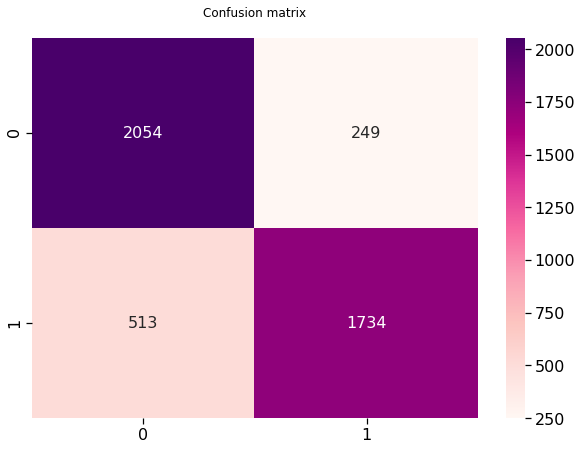

Text(0.5, 1.0, 'Confusion matrix\n')

In [ ]:
fig, axes = plt.subplots(figsize=(10, 7))

sns.heatmap(
    confusion_matrix, 
    annot=True,
    cmap="RdPu" , 
    fmt='g',
    annot_kws={"size":16}
)
plt.title('Confusion matrix\n')

In [ ]:
countview(test_df, 'income')

Out[45]:

,income,count,percentage_of_each_value
0,<=50K,2385,4.88
1,>50K,2258,4.62


In [ ]:
countview(train_df, 'income')

Out[59]:

,income,count,percentage_of_each_value
0,<=50K,9483,19.42
1,>50K,9429,19.31


**<h3><font style='color:#bd7f0d'>Final Conclusion<font></h1>**<br>

Now, based on the above analysis with different methods I can conclude that our classification model accuracy is very good. Our model is doing a very good job in terms of predicting the class labels even after down sampling
  
<hr />

__While single decision tree does not had a good evaluation metrics result, random forest and gbtr have improved the performance. unfortunately, I could not find the best model for gbtr. I assumed it could be performed better than this result.__ All in all, Random forest performs better.
  <hr />
**<h4><font style='color:green'>Final results:<font></h4>**<br>
  
 
Method: __Random Forest__ with parameters<br />
maxDepth  : 15     
impurity  : gini <br/>
numTrees  : 120     
     
ROC AUC __0.92__<br />

In [ ]:
# https://github.com/gtolomei/big-data-computing
# https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45
# https://github.com/gtolomei/big-data-computing/blob/master/notebooks/Classification.ipynb
# https://github.com/gtolomei/big-data-computing/blob/master/slides/10_Logistic_Regression.pdf
# https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253
# https://stackoverflow.com/questions/50363463/linearsvc-missing-in-apache-spark-2-1-non-linear-kernels-in-spark-2-2
# https://stackoverflow.com/a/38781980
# https://stackoverflow.com/a/63910523
# https://spark.apache.org/docs/3.0.0-preview/mllib-decision-tree.html
# And Many more…..
